# 1. <a id='toc1_'></a>[科学技術計算 4](#toc0_)

この演習トピックでは，連立一次方程式の数値解法を学ぶ．まず，線形代数の基礎知識として逆行列や行列式について復習し，次に数値的に効率的で安定な数値解法手法を学ぶ．その中でも，直接法であるGaussの消去法やLU分解，反復法であるJacobi法，Gauss-Seidel法などの解法を理解する．また連立方程式の解の精度を評価するための行列ノルムや条件数についても学ぶ．

線形代数については，各自の教科書・テキストを参考にすること．


In [1]:
import numpy as np
from numpy.linalg import inv, norm, solve, det, matrix_rank, cond
from numpy import diag
rng = np.random.default_rng()

import scipy

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.bbox"] = "tight"

import warnings
warnings.simplefilter('ignore', FutureWarning)

from typing import Tuple, List, Optional, Union
from tqdm.auto import tqdm


**目次**<a id='toc0_'></a>    
- 1. [科学技術計算 4](#toc1_)    
  - 1.1. [線形代数の復習](#toc1_1_)    
    - 1.1.1. [逆行列](#toc1_1_1_)    
    - 1.1.2. [連立方程式](#toc1_1_2_)    
  - 1.2. [連立方程式の数値解法](#toc1_2_)    
    - 1.2.1. [逆行列は用いない](#toc1_2_1_)    
      - 1.2.1.1. [注意：富豪的プログラミング](#toc1_2_1_1_)    
    - 1.2.2. [行列式が0かは判定しない](#toc1_2_2_)    
      - 1.2.2.1. [行列式の定義](#toc1_2_2_1_)    
      - 1.2.2.2. [numpyの行列式計算](#toc1_2_2_2_)    
      - 1.2.2.3. [「行列式が0である」の判定の安定性](#toc1_2_2_3_)    
    - 1.2.3. [LU分解：行列式計算の数値解法](#toc1_2_3_)    
    - 1.2.4. [連立方程式のソルバー](#toc1_2_4_)    
      - 1.2.4.1. [numpyのソルバー](#toc1_2_4_1_)    
      - 1.2.4.2. [scipyのソルバー](#toc1_2_4_2_)    
      - 1.2.4.3. [LAPACKのソルバー](#toc1_2_4_3_)    
      - 1.2.4.4. [コードでは逆行列を用いず，ソルバーを用いる](#toc1_2_4_4_)    
      - 1.2.4.5. [計算速度と精度](#toc1_2_4_5_)    
    - 1.2.5. [連立方程式の数値解法の種類](#toc1_2_5_)    
  - 1.3. [直接法：Gaussの消去法](#toc1_3_)    
    - 1.3.1. [前進消去](#toc1_3_1_)    
      - 1.3.1.1. [前進消去：1行目](#toc1_3_1_1_)    
      - 1.3.1.2. [前進消去：2行目](#toc1_3_1_2_)    
      - 1.3.1.3. [前進消去：$j$行目](#toc1_3_1_3_)    
    - 1.3.2. [後退代入](#toc1_3_2_)    
      - 1.3.2.1. [後退代入：$n$行目](#toc1_3_2_1_)    
      - 1.3.2.2. [後退代入：$n-1$行目](#toc1_3_2_2_)    
      - 1.3.2.3. [後退代入：$n-k$行目](#toc1_3_2_3_)    
      - 1.3.2.4. [後退代入：まとめ](#toc1_3_2_4_)    
    - 1.3.3. [前進消去とLU分解](#toc1_3_3_)    
      - 1.3.3.1. [基本変形行列$M_j$による前進消去](#toc1_3_3_1_)    
      - 1.3.3.2. [基本変形行列の積による下三角行列$L$の構築](#toc1_3_3_2_)    
      - 1.3.3.3. [LU分解のアルゴリズム](#toc1_3_3_3_)    
      - 1.3.3.4. [LU分解を用いた連立方程式の解法](#toc1_3_3_4_)    
      - 1.3.3.5. [前進消去の効率的な実装](#toc1_3_3_5_)    
    - 1.3.4. [ピボット選択](#toc1_3_4_)    
      - 1.3.4.1. [部分ピボット選択](#toc1_3_4_1_)    
      - 1.3.4.2. [完全ピボット選択](#toc1_3_4_2_)    
      - 1.3.4.3. [部分ピボット選択とPLU分解](#toc1_3_4_3_)    
        - 1.3.4.3.1. [置換行列$P_j$による部分ピボット選択](#toc1_3_4_3_1_)    
        - 1.3.4.3.2. [置換行列と基本変形行列の関係](#toc1_3_4_3_2_)    
      - 1.3.4.4. [部分ピボット選択つきLU分解のアルゴリズム](#toc1_3_4_4_)    
      - 1.3.4.5. [部分ピボット選択つきの前進消去の実装](#toc1_3_4_5_)    
    - 1.3.5. [LU分解を用いた連立方程式の解法](#toc1_3_5_)    
      - 1.3.5.1. [多数の連立方程式を解く場合](#toc1_3_5_1_)    
      - 1.3.5.2. [scipyの実装：`lu_factor()`と`lu_solve()`](#toc1_3_5_2_)    
  - 1.4. [直接法：コレスキー分解](#toc1_4_)    
    - 1.4.1. [LU分解の復習](#toc1_4_1_)    
    - 1.4.2. [コレスキー分解](#toc1_4_2_)    
  - 1.5. [反復法](#toc1_5_)    
    - 1.5.1. [反復法の更新則](#toc1_5_1_)    
      - 1.5.1.1. [反復法の更新則1](#toc1_5_1_1_)    
      - 1.5.1.2. [反復法の更新則2](#toc1_5_1_2_)    
    - 1.5.2. [Jacobi法](#toc1_5_2_)    
      - 1.5.2.1. [収束条件](#toc1_5_2_1_)    
      - 1.5.2.2. [実装](#toc1_5_2_2_)    
      - 1.5.2.3. [コールバック](#toc1_5_2_3_)    
    - 1.5.3. [Gauss-Seidel法](#toc1_5_3_)    
      - 1.5.3.1. [収束条件](#toc1_5_3_1_)    
      - 1.5.3.2. [実装](#toc1_5_3_2_)    
    - 1.5.4. [SOR法](#toc1_5_4_)    
  - 1.6. [連立方程式の解の精度の評価](#toc1_6_)    
    - 1.6.1. [行列ノルム](#toc1_6_1_)    
      - 1.6.1.1. [作用素ノルム](#toc1_6_1_1_)    
      - 1.6.1.2. [行列の$p$ノルム](#toc1_6_1_2_)    
      - 1.6.1.3. [誘導ノルム以外のノルム](#toc1_6_1_3_)    
      - 1.6.1.4. [numpyの行列ノルム](#toc1_6_1_4_)    
      - 1.6.1.5. [ノルムの性質](#toc1_6_1_5_)    
    - 1.6.2. [条件数](#toc1_6_2_)    
      - 1.6.2.1. [係数行列への誤差](#toc1_6_2_1_)    
      - 1.6.2.2. [条件数](#toc1_6_2_2_)    
      - 1.6.2.3. [右辺ベクトルへの誤差](#toc1_6_2_3_)    
      - 1.6.2.4. [係数行列と右辺への誤差](#toc1_6_2_4_)    
      - 1.6.2.5. [numpyの条件数](#toc1_6_2_5_)    
    - 1.6.3. [条件数による連立方程式の解の精度評価](#toc1_6_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1.1. <a id='toc1_1_'></a>[線形代数の復習](#toc0_)

### 1.1.1. <a id='toc1_1_1_'></a>[逆行列](#toc0_)

連立方程式の解法を学ぶ前に，逆行列について復習しておく．

まず，$n$次の正方行列$A$が正則であるとは，行列式$\mathrm{det}(A) \neq 0$であることを指す．正則な行列には**逆行列**$A^{-1}$が存在し，次のような関係が成り立つ．


- $A A^{-1} = A^{-1} A = I$

ここで$I$は単位行列である．

numpyで逆行列を計算するには`np.linalg.inv()`を用いる．

- https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html
    > Compute the inverse of a matrix.

In [2]:
n = 3
A = rng.random(size=(n, n))
I = np.eye(n)

print("A\n", A, sep="")
print("A^-1\n", inv(A), sep="")
print("A A^-1\n", A @ inv(A), sep="")
print("A^-1 A\n", inv(A) @ A, sep="")
print("A^-1 A == I", np.allclose(A @ inv(A), I))


A
[[0.44668677 0.49285306 0.03005491]
 [0.07926796 0.52123588 0.5982072 ]
 [0.92248815 0.04312664 0.0500533 ]]
A^-1
[[ 1.13725737e-03 -9.13707214e-02  1.09132543e+00]
 [ 2.14178449e+00 -2.09817112e-02 -1.03529093e+00]
 [-1.86635179e+00  1.70205106e+00  7.57469375e-01]]
A A^-1
[[ 1.00000000e+00  2.65527073e-19  8.65446587e-17]
 [-7.20999467e-19  1.00000000e+00  8.13237032e-17]
 [ 3.78545135e-18  6.42007115e-18  1.00000000e+00]]
A^-1 A
[[ 1.00000000e+00  6.11565798e-19 -5.68788804e-19]
 [ 3.24928517e-16  1.00000000e+00  2.01710744e-17]
 [-7.91171382e-17  4.08157302e-17  1.00000000e+00]]
A^-1 A == I True


### 1.1.2. <a id='toc1_1_2_'></a>[連立方程式](#toc0_)

次に，今回のメインテーマである**連立方程式**について説明する．これは線形代数の重要なトピックであり，数値計算でも頻繁に利用される．

次のような$n$元連立一次方程式を考える．

\begin{gather*}
    a_{11} x_1 + a_{12} x_2 + \cdots + a_{1n} x_n = b_1 \\
    a_{21} x_1 + a_{22} x_2 + \cdots + a_{2n} x_n = b_2 \\
    \vdots \\
    a_{n1} x_1 + a_{n2} x_2 + \cdots + a_{nn} x_n = b_n
\end{gather*}

ここで，$a_{ij}$は係数，$x_j$は変数，$b_i$は定数である．
この連立方程式は，$n$次正方係数行列$A \in R^{n\times n}$，解ベクトル$\boldsymbol{x} \in R^n$，および右辺ベクトル$\boldsymbol{b} \in R^n$を使って，次のように行列表現できる．

\begin{align*}
A \boldsymbol{x} &= \boldsymbol{b}
\end{align*}

具体的には，次のように書き下せる．

\begin{align*}
\begin{pmatrix}
a_{11} & a_{12} & \cdots & a_{1n} \\
a_{21} & a_{22} & \cdots & a_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{pmatrix}
\begin{pmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{n}
\end{pmatrix}
&=
\begin{pmatrix}
b_1 \\
b_2 \\
\vdots \\
b_n
\end{pmatrix}
\end{align*}

係数行列$A$が正則である場合，つまり行列式$\mathrm{det}(A) \neq 0$で，逆行列$A^{-1}$が存在する場合には，この連立方程式の解$\boldsymbol{x}$は次式で求められる．

$$
\boldsymbol{x} = A^{-1} \boldsymbol{b}
$$

つまり，行列$A$の逆行列を使って，右辺ベクトル$\boldsymbol{b}$から解を求めることができる．

また，得られた解が正しいかどうかを確認するために残差ベクトル$\boldsymbol{r}$を計算する．これは，$A \boldsymbol{x}$と$\boldsymbol{b}$の差で定義される．

$$
\boldsymbol{r} = A \boldsymbol{x} - \boldsymbol{b}
$$

もし，この残差ベクトルがゼロ，つまり$\| \boldsymbol{r} \| = 0$ならば，$\boldsymbol{x}$は厳密解であることを意味する．


In [3]:
n = 3
A = rng.random(size=(n, n))
b = rng.random(n)

print("A\n", A, sep="")
print("b", b)

x = inv(A) @ b
print("x", x)
r = A @ x - b
print("Ax - b", r)
print("||Ax - b||", norm(r))


A
[[0.27300727 0.03702452 0.09598739]
 [0.53812477 0.55654184 0.02408969]
 [0.00509799 0.51733037 0.38219052]]
b [0.35828669 0.33969784 0.61785173]
x [ 0.69858218 -0.14304396  1.80091165]
Ax - b [5.55111512e-17 1.11022302e-16 1.11022302e-16]
||Ax - b|| 1.6653345369377348e-16


## 1.2. <a id='toc1_2_'></a>[連立方程式の数値解法](#toc0_)

### 1.2.1. <a id='toc1_2_1_'></a>[逆行列は用いない](#toc0_)

数値的に連立方程式を解く際には，「$A$の逆行列を計算して$b$と掛ける」という方法は通常使われない．これは，逆行列の計算が数値的に安定していないうえに，他にもっと効率的で安定した解法が多く存在するためである．実際の計算では，行列の性質に応じて最適なアルゴリズムを選択するのが一般的であり，それによって計算の安定性や効率を向上させることができる．

- [渡部善隆, 連立1次方程式の基礎知識　〜およびGaussの消去法の安定性について〜, 数値解析チュートリアル2004資料, 2004年3月. p.2](https://ri2t.kyushu-u.ac.jp/~watanabe/RESERCH/MANUSCRIPT/TUTORIAL/leq.pdf)
    > ただし，実際の数値計算で逆行列$A^{−1}$を露骨に計算にいくことはそんなに多くありません．$A^{-1}$がきちんとわからなくても，式(1.2)（$A \boldsymbol{x} = \boldsymbol{b}$）をみたす$\boldsymbol{x}$を求める効率のよい方法がたくさんあるからです．それらの方法に比べ，逆行列を計算し，積$A^{−1} \boldsymbol{b}$の計算で$\boldsymbol{x}$を求める方法は，多くの手間がかかり，精度もあまりよくない上，普通は記憶領域を大量に消費します．そのため，逆行列の値がすべて必要になるなどの特別なことがない限り，式(1.3)（$\boldsymbol{x} = A^{-1} \boldsymbol{b}$）の計算を行なわないのが"常識"になっています．
- [Golub & Van Loan, Matrix Computation, 4th ed., Johns Hopkins Univ Press, 2013](https://www.press.jhu.edu/books/title/10678/matrix-computations), p135, 3.4.9. The LU Mentality.
    > An "$A^{-1}$" in a formula almost always means "solve a linear system" and almost never means "compute $A^{-1}$".
- 名取亮, 線形計算, 朝倉書店, 1993.
    > - $A^{-1}$を計算しようとすると（中略）ガウスの消去法で連立方程式を解く演算量の3倍の演算量が必要です．(p.41)
    > - 逆行列は式の中にしばしば現れます．しかし，必ずしも逆行列を計算する必要はありません．(p.52)

#### 1.2.1.1. <a id='toc1_2_1_1_'></a>[注意：富豪的プログラミング](#toc0_)

この演習で扱うような小規模な行列については，現在では計算量をほとんど気にする必要はない．たとえば，以下の例では行列式の値を毎回`det()`で計算しているが，これは可読性を高めるためである（実際には計算量が多いため，一度計算したら一時変数に保存するほうが効率的である）．現代の計算機はリソースが豊富であるため，メモリ使用量や計算量を少し減らすための小さな工夫は必要ない．これを「[富豪的プログラミング](http://www.pitecan.com/fugo.html)」という．

しかし，大規模な行列やデータを扱うアルゴリズムでは，定数倍の計算量削減も重要になる．その場合，小手先の工夫で計算量やメモリ使用量を減らすだけでは十分ではなく，アルゴリズム自体の改善が求められる．

この資料では，数値解析分野でよく知られた**計算量を削減し，数値的に安定な手法を説明する**．ただし，**デモンストレーションのために実行するコードは，可読性を重視している**ため，計算量について深く考慮していない「富豪的プログラミング」の一例である．これらの違いを混同しないように注意すること．

### 1.2.2. <a id='toc1_2_2_'></a>[行列式が0かは判定しない](#toc0_)

数学的には，行列の行列式が $\mathrm{det}(A) \neq 0$ であるならば，逆行列 $A^{-1}$ が存在し，連立方程式の解は次のように表される．

$$
\boldsymbol{x} = A^{-1}\boldsymbol{b}
$$

つまり，連立方程式を解く前に行列 $A$ の行列式が 0 でないかどうかを確認する必要がある．


しかし，実際に数値計算を行う際には，いくつかの問題点を考慮しなければならない．まず，行列式計算における浮動小数点数に起因する誤差があり，そのためオーバーフローしない数値的に安定な計算方法が必要である．

さらに，行列式の計算は非常に計算コストがかかることが多いため，行列式を求める際には計算量にも配慮する必要がある．したがって，数値計算では，行列式を直接計算するのではなく，より効率的な方法で連立方程式を解くことが一般的である．

#### 1.2.2.1. <a id='toc1_2_2_1_'></a>[行列式の定義](#toc0_)

行列式の定義は以下のように表される．

$$
\mathrm{det}(A) =
\sum_{\sigma \in S_n}
\mathrm{sgn}(\sigma)
a_{1 \sigma(1)}
a_{2 \sigma(2)}
\cdots
a_{n \sigma(n)}
$$

ここで，

- $\sigma$ は置換を表し，
- $S_n$ は $n!$ 通りのすべての置換の集合，
- $\mathrm{sgn}(\sigma)$ は置換の符号であり，奇置換なら $-1$，偶置換なら $+1$ である．

つまり，行列式は行列の各行から1個ずつ選んだ$n$個の数値の積を計算し，それをすべての置換について求めた $n!$ 個の積の総和として定義される．

- https://ja.wikipedia.org/wiki/%E7%BD%AE%E6%8F%9B_(%E6%95%B0%E5%AD%A6)
- https://ja.wikipedia.org/wiki/%E7%BD%AE%E6%8F%9B%E3%81%AE%E7%AC%A6%E5%8F%B7
    > 置換 $\sigma$ の符号 (sign) あるいは符号数 (signature) $\mathrm{sgn}(\sigma)$ は、$\sigma$ が偶置換ならば $+1$, 奇置換ならば $−1$ を割り当てる。





なお，$ n = 100 $ の場合，行列式の定義に基づく総和計算の個数は $ n! $ となり，その値は以下の通り非常に大きな数となる．

\begin{align*}
100!
&\simeq 9.33 \times 10^{157} \\
&= 93326215443944152681699238856266700490715968264381621468592963895217599993229915608941463976156518286253697920827223758251185210916864000000000000000000000000
\end{align*}

これだけの規模の総和計算では，1e-16程度の浮動小数点数の丸め誤差でも無視できなくなり，さらにこのような大規模な総和計算自体が現実的ではない．

実際の数値計算では，行列式を直接計算するのではなく，より効率的で数値的に安定した手法を用いる．そのための手法がこの資料で説明する**LU分解**である．




#### 1.2.2.2. <a id='toc1_2_2_2_'></a>[numpyの行列式計算](#toc0_)


numpyの行列式計算の関数`np.linalg.det()`では，
この乱数行列の作成方法の場合には，n=600程度でオーバーフローする．

- [`np.linalg.det()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.det.html)
    > Compute the determinant of an array.



In [4]:
n = 500
A = rng.random(size=(n, n))
print("det(A)", det(A))

n = 600
A = rng.random(size=(n, n))
print("det(A)", det(A))


det(A) -1.5568120853753848e+298
det(A) inf


c:\Users\sayuk\anaconda3\envs\myenv\Lib\site-packages\numpy\linalg\_linalg.py:2431: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


オーバーフローの基本的な対策は，計算に対数を利用する方法である．`numpy`には行列式の対数を計算するための関数 `np.linalg.slogdet()` が用意されている．`np.linalg.slogdet()` は，行列の符号と行列式の対数値 `log(det(A))` を返すもので，これを使うことでオーバーフローを回避することができる．

- [`numpy.linalg.slogdet()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.slogdet.html)
    > Compute the sign and (natural) logarithm of the determinant of an array.
    - 内部的には，LAPACKのLU分解([getrf](https://github.com/Reference-LAPACK/lapack/blob/master/SRC/dgetrf.f))を利用している．


ただし，この対数値を使って再び行列式の値を求めるために `exp()` を使用すると，再びオーバーフローを起こす可能性があるため注意が必要である．

In [5]:
s, log_det_A = np.linalg.slogdet(A)
print(f"det(A) = {s} * exp({log_det_A})")


det(A) = 1.0 * exp(879.3346741946659)


#### 1.2.2.3. <a id='toc1_2_2_3_'></a>[「行列式が0である」の判定の安定性](#toc0_)

行列のサイズ $n$ がオーバーフローするほど大きくなくても，行列式の計算における数値的安定性は重要な問題であり，行列式が0かどうかを判定することは難しい場合がある．

線形代数で学んだように、以下の条件は本来互いに等価であるはずである．

- $ n $ 次正方行列 $ A $ が正則である．
- $ A $ の $ n $ 個の列が一次独立である．
- $ \mathrm{rank}(A) = n $，つまり $ A $ がフルランクである．
- $ \mathrm{det}(A) \neq 0 $，つまり行列式が0ではない．

しかし，実際の数値計算では，これらの条件を判定する際に誤差が発生するため，完全な一致は期待できない．以下では，$ n = 100 $ 程度の例を考えて，この問題を具体的に説明する．

1. **ランダムな行列を作成**：まず，ランダムな行列 $ A $ を作成する．ランダムで生成された列ベクトルは（ほとんどの場合）一次独立であり，行列式は0ではなく，ランクは $ n $ であるはずである．

2. **列の置換による一次従属性の導入**：次に，行列の1列目 $ A[:, 0] $ を2列目 $ A[:, 1] $ で置き換える．これにより，同じ列が2つ存在することになり，列ベクトルは一次従属となる．この場合，行列式は0，ランクは $ n - 1 $ になるはずである．

3. **ノイズの追加**：最後に，1列目 $ A[:, 0] $ を2列目 $ A[:, 1] $ で置き換えた後，微小なノイズを加える．ノイズがあるため，列ベクトルは（ほとんどの場合）一次独立となり，行列式は0ではなく，ランクは再び $ n $ であるはずである．しかし，ノイズが非常に小さい場合，実際には一次従属かもしれず，行列式が0近くになるかもしれない．

以下のコードは，これらの操作を行った際の行列式とランクを計算した結果である．

- 1つ目のケースでは，`det()` の結果は期待通り0ではなく，`matrix_rank()` の結果は100である．
- 2つ目のケースでは，行列式は0であるべきだが，`det()` の結果は実際には0ではない．しかし，`matrix_rank()` は期待通り99である．
- 3つ目のケースでは，微小なノイズを加えたにもかかわらず，`det()` の結果は非常に大きくなり，`matrix_rank()` の結果はしきい値によって変動し，安定しない．

このように，`det()`や`matrix_rank()`などを用いて行列式や行列のランクを計算し，その結果で逆行列が存在するかを判定するのは，数値誤差が影響しやすく，適切ではない．

- [`numpy.linalg.matrix_rank()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.matrix_rank.html)
    > Return matrix rank of array using SVD method.


In [6]:
# n = 10
n = 100
A = rng.random(size=(n, n))
print("det(A)", det(A))
print("rank(A)", matrix_rank(A))
print("rank(A)", matrix_rank(A, tol=1e-4))

B = A.copy()
B[:, 0] = B[:, 1].copy()  # 重複した列を持つ
print("det(B)", det(B))
print("rank(B)", matrix_rank(B))
print("rank(B)", matrix_rank(B, tol=1e-4))

B = A.copy()
B[0] = B[1].copy()  # 重複した行を持つ
print("det(B)", det(B))
print("rank(B)", matrix_rank(B))
print("rank(B)", matrix_rank(B, tol=1e-4))

C = A.copy()
C[:, 0] = C[:, 1].copy() + rng.random(n) * 1e-4
print("det(C)", det(C))
print("rank(C)", matrix_rank(C))
print("rank(C)", matrix_rank(C, tol=1e-4))


det(A) 2.4703295625565838e+26
rank(A) 100
rank(A) 100
det(B) 4121742612.295248
rank(B) 99
rank(B) 99
det(B) -41299207219.18492
rank(B) 99
rank(B) 99
det(C) 2.059067173217783e+22
rank(C) 100
rank(C) 99




### 1.2.3. <a id='toc1_2_3_'></a>[LU分解：行列式計算の数値解法](#toc0_)


$A \in R^{n \times n}$の[LU分解](https://en.wikipedia.org/wiki/LU_decomposition)とは，
置換行列$P$，単位下三角行列（対角要素は1）$L$，上三角行列$U$を用いて
$$
A = PLU
$$
と分解することである．ここで行列はすべて$n$次正方行列である．

すると
$$
|A|
=
|P| |L| |U|
=
|P| \prod_i u_{ii}
$$
ここで
\begin{align*}
|L| &= 1 \\
|P| &= \pm 1 \\
|U| &= \prod_i u_{ii}
\end{align*}

である．

In [7]:
P, L, U = scipy.linalg.lu(A)
print("det(A) = det(P) det(L) det(U)")
print("det(L) == 1", np.isclose(det(L), 1))
print("det(P) == +/-1", np.isclose(abs(det(P)), 1))
print("det(U) == prod_i u_ii", np.isclose(diag(U).prod(), det(U)))
print(f"det(A) == det(P) prod_i u_ii",
      np.isclose(det(A), det(P) * det(L) * diag(U).prod()))


det(A) = det(P) det(L) det(U)
det(L) == 1 True
det(P) == +/-1 True
det(U) == prod_i u_ii True
det(A) == det(P) prod_i u_ii True


以下で説明するGaussの消去法では，実質的にLU分解を行い上三角行列 $ U $ を求めている．そのため，

- 行列式を計算するための計算量は，連立方程式を解くための計算量とほぼ同じ

である．

実際には，連立方程式を解く過程でLU分解を行うことで，行列 $ U $ とその行列式 $ \mathrm{det}(U) $ の値を得ることができる．したがって，「行列式を計算してそれが0かどうかを判定し，その結果によって連立方程式を解くかどうかを判断する」という方法には実質的な意味がない．

### 1.2.4. <a id='toc1_2_4_'></a>[連立方程式のソルバー](#toc0_)

#### 1.2.4.1. <a id='toc1_2_4_1_'></a>[numpyのソルバー](#toc0_)


連立方程式を解くために，numpyでは`np.linalg.solve()`というソルバーが提供されている．この関数は，逆行列を明示的に計算することなく，連立方程式を直接解くためのものである．

`np.linalg.solve()`の引数は，係数行列`A`と右辺ベクトル`b`で，返り値は連立方程式の解であるベクトル`x`である．このソルバーは，行列$A$がフルランクである（つまり正則である）場合に解を求めるものである．

- https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html
    > Solve a linear matrix equation, or system of linear scalar equations.
    > Computes the “exact” solution, x, of the well-determined, i.e., full rank, linear matrix equation ax = b.


In [8]:
n = 10
A = rng.random(size=(n, n))
b = rng.random(n)

x = solve(A, b)
print("||Ax - b||", norm(A @ x - b))

||Ax - b|| 5.495323605393213e-16



#### 1.2.4.2. <a id='toc1_2_4_2_'></a>[scipyのソルバー](#toc0_)

scipyでも連立方程式を解くためのソルバーが提供されている．一般的な行列に対するソルバーは`scipy.linalg.solve()`であり，numpyと同様に係数行列`A`と右辺ベクトル`b`を引数に取り，解`x`を返す．

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html
    > Solves the linear equation set a @ x == b for the unknown x for square a matrix.

`scipy.linalg.solve()`のキーワード引数`assume_a`を使って，行列の種類を指定することができ，これにより適切なアルゴリズムを選択できる．

- 一般(general)の行列の場合：`assume_a="gen"`
- 対称(symmetric)行列の場合：`assume_a="sym"`
- 正定値(positive definite)行列の場合：`assume_a="pos"`

さらに，scipyでは特定の種類の行列（例えば対称行列や三角行列）に対して，専用のソルバーが提供されている．これらのソルバーを適切に選んで使用することで，計算がより効率的になる．

- 帯行列用：[solve_banded](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html)
- 正定値対称帯行列用：[solveh_banded](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solveh_banded.html)
- 三角行列用：[solve_triangular](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html)
- 巡回行列用：[solve_circulant](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_circulant.html)
- テプリッツ行列用：[solve_toeplitz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_toeplitz.html)

In [9]:
x = scipy.linalg.solve(A, b)
print("||Ax - b||", norm(A @ x - b))


||Ax - b|| 5.495323605393213e-16


#### 1.2.4.3. <a id='toc1_2_4_3_'></a>[LAPACKのソルバー](#toc0_)

上記の関数の内部的には，LAPACKの関数を利用している．


- 一般行列用：[dgesv](https://github.com/Reference-LAPACK/lapack/blob/master/SRC/dgesv.f)
- 実対称行列用：[dsysv](https://github.com/Reference-LAPACK/lapack/blob/master/SRC/dsysv.f)
- 正定値実対称行列用：[dposv](https://github.com/Reference-LAPACK/lapack/blob/master/SRC/dposv.f)
- 三重対角行列用：[dgtsv](https://github.com/Reference-LAPACK/lapack/blob/master/SRC/dgtsv.f)
- 帯行列用：[dgbsv](https://github.com/Reference-LAPACK/lapack/blob/master/SRC/dgbsv.f)
- 三角行列用：[dtrtrs](https://github.com/Reference-LAPACK/lapack/blob/master/SRC/dtrtrs.f)


#### 1.2.4.4. <a id='toc1_2_4_4_'></a>[コードでは逆行列を用いず，ソルバーを用いる](#toc0_)

理論的に導出される各種の手法は，その式中に逆行列を含むことが多い．
しかし上述のように，実装では逆行列を用いるのではなく，連立方程式ソルバーを用いる．

数式中に逆行列がある場合に，実装のコード中で`inv()`を`solve()`に置き換える例のいくつかを示す．
これらは次回以降も登場するテクニックである．

- $\boldsymbol{x} = A^{-1}\boldsymbol{b}$
    - NG: `x = inv(A) @ b`
    - OK: `x = solve(A, b)`
- $\boldsymbol{y} = \boldsymbol{x} + D^{-1}\boldsymbol{f}$
    - NG: `y = x + inv(D) @ f`
    - OK: `y = x + solve(D, f)`
- $\boldsymbol{y} = \boldsymbol{x}^T D (D^T D + I)^{-1} D^T \boldsymbol{x}$
    - NG: `y = x @ D @ inv(D.T @ D + I) @ D.T @ x`
    - OK: `y = x @ D @ solve(D.T @ D + I, D.T @ x)`


#### 1.2.4.5. <a id='toc1_2_4_5_'></a>[計算速度と精度](#toc0_)

応用においては，nは1e3から（大規模なものでは）1e8のような問題を扱うことがある．

例えばn=3000を考えると，
逆行列を用いる方法の結果は以下のようになる．

In [10]:
n = 3000
A = rng.random(size=(n, n))
b = rng.random(n)

x = inv(A) @ b
print("||Ax - b||", norm(A @ x - b))

x = solve(A, b)
print("||Ax - b||", norm(A @ x - b))


||Ax - b|| 8.031575702518554e-11
||Ax - b|| 9.559834519734277e-11


上記から分かるように，`np.linalg.solve()`を用いる方が残差$\|A \bm{x} - \bm{b}\|$は半分から7割程度になる．

以下は計算時間の比較である．`np.linalg.solve()`のほうが2倍程度速いことが分かる．

In [11]:
%timeit x = inv(A) @ b
%timeit x = np.linalg.solve(A, b)
%timeit x = scipy.linalg.solve(A, b)


846 ms ± 61.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
314 ms ± 30.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
518 ms ± 23.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 1.2.5. <a id='toc1_2_5_'></a>[連立方程式の数値解法の種類](#toc0_)

連立方程式を数値的に解く手法は，
厳密解（丸め誤差の影響を除く）が得られるかどうか，
反復回数が有限かどうかにより，
大きく分けて以下の3種類<sup>2</sup>がある．

- 直接法：有限回の演算で厳密解が得られる手法
  - メモリ使用量が反復法よりも多い
  - 計算量は$O(n^3)$である
  - 計算結果が密になるため疎行列には向いていない
  - 有名な手法
    - **Gaussの消去法**：LU分解法
      - **部分ピボット選択付きGaussの消去法**
      - 完全ピボット選択付きGaussの消去法
    - Gauss-Jordanの消去法（線形代数で学ぶ手法で，行列の対角成分を1にし，単位行列に変換するまで操作を行う「掃き出し法」）
    - Cholesky法：正定値対称行列の場合
- （定常）反復法：初期値から出発し，解へ収束するまで反復を繰り返す手法
  - 疎行列の利点を活用できるため，大規模疎行列に適用できる
  - 打ち切り誤差が生じるため，有限回の反復では厳密解は得られない
  - 反復回数にも依存するが，計算量は直接法より少なくなる
    - ただし，収束までの反復回数の見積もりが難しい
    - さらに，収束条件を満たさない場合には収束しないことがある
  - 有名な手法
    - **Jacobi法**：優対角行列の場合
    - **Gauss-Seidel法**：優対角行列または正定値対称行列の場合
    - **SOR法**：正定値対称行列の場合
- クリロフ部分空間法（非定常反復法）<sup>3</sup>
  - 正定値対称行列の場合
    - 共役勾配法 (Conjugate-Gradient, CG)：初期値から始めて，有限回の反復で厳密解が得られる
      - 前処理付き共役勾配法
  - 非対称行列の場合
    - 一般化最小残差法 (generalized miimal residual method, GMRES)


**直接法と反復法の使い分け**

以下で説明する部分ピボット選択付きGaussの消去法は，相対誤差を小さく保つことが保証されており，小規模な一般の密行列が係数行列の場合に広く用いられている．また，係数行列が正定値対称である場合にはCholesky法が適用される．

一方，大規模疎行列を扱う場合には，係数行列が正定値対称であれば共役勾配法 (CG) が，そうでない場合にはGauss-Seidel法などの反復法が用いられることが一般的である．


- <sup>1</sup> [Gene H. Golub, Charles F. Van Loan, Matrix Computations, 4th edition, Johns Hopkins Univ Press, 2012](https://www.press.jhu.edu/books/title/10678/matrix-computations), 3 General Linear Systems, 4 Special Linear Systems, 11 Large Sparse Linear Systems.
- <sup>2</sup>
  - [岩波数学辞典, 第4版, 岩波書店, 2007.](https://www.iwanami.co.jp/book/b256653.html) 510 連立1次方程式の数値解法, pp.1665-1670.
  - [朝倉 数学ハンドブック 応用編, 朝倉書店, 2011.](https://www.asakura.co.jp/detail.php?book_code=11130) V.2 連立1次方程式, pp.285-298.
- <sup>3</sup>
  - [Henk A. van der Vorst, Iterative Krylov Methods for Large Linear Systems, Cambridge University Press, 2003.](https://www.cambridge.org/core/books/iterative-krylov-methods-for-large-linear-systems/FFB93854B3C47699F045AC396C0A208F)
  - [Yousef Saad, Iterative Methods for Sparse Linear Systems, 2nd edition, Society for Industrial and Applied Mathematics, 2003](https://epubs.siam.org/doi/book/10.1137/1.9780898718003)
  - [岩波数学辞典, 第4版, 岩波書店, 2007.](https://www.iwanami.co.jp/book/b256653.html) 510D クリロフ部分空間法, pp.1667-1670.


## 1.3. <a id='toc1_3_'></a>[直接法：Gaussの消去法](#toc0_)

連立方程式$A \boldsymbol{x} = \boldsymbol{b}$の係数行列$A$が，正方かつ正則であると（とりあえず）仮定する．

Gaussの消去法は，変数$\boldsymbol{x} = (x_1, x_2, \ldots, x_n)^T \in R^n$の変数を
$x_2, x_3, \ldots, x_n$の順に1つづつ消去する**前進消去**と，
$x_n, x_{n-1}, \ldots, x_1$の順に1つずつ代入して値を求める**後退代入**の2ステップからなる．

### 1.3.1. <a id='toc1_3_1_'></a>[前進消去](#toc0_)

前進消去は，連立方程式の初歩的な解法の一つである加減法を，系統立てて実行し，変数を一つずつ消去する．

#### 1.3.1.1. <a id='toc1_3_1_1_'></a>[前進消去：1行目](#toc0_)

まず以下の連立方程式を考える．


\begin{align*}
\begin{pmatrix}
a_{11} & a_{12} & \cdots & a_{1n} \\
a_{21} & a_{22} & \cdots & a_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{pmatrix}
\begin{pmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{n}
\end{pmatrix}
&=
\begin{pmatrix}
b_1 \\
b_2 \\
\vdots \\
b_n
\end{pmatrix}
\end{align*}

この式の，$j=1$行目と，それ以降の$i=2,\ldots,n$行目に注目する．

\begin{align*}
    a_{11} x_1 + a_{12} x_2 + \cdots + a_{1n} x_n &= b_1 \\
    a_{i1} x_1 + a_{i2} x_2 + \cdots + a_{in} x_n &= b_i
\end{align*}

まず，1行目を$r_{i1} = a_{i1}/a_{11}$倍する．

\begin{align*}
	r_{i1} a_{11} x_1 + r_{i1} a_{12} x_2 + \cdots + r_{i1} a_{1n} x_n &= r_{i1} b_1
	\\
	a_{i1} x_1 + r_{i1} a_{12} x_2 + \cdots + r_{i1} a_{1n} x_n  &=  r_{i1} b_1
\end{align*}

次に$r_{i1}$倍した1行目を$i$行目から引いて，$x_1$を$i$行目から消去する．

\begin{align*}
	a_{i1} x_1 &+& r_{i1} a_{12} x_2 &+& \cdots &&+&& r_{i1} a_{1n} x_n  &= r_{i1} b_1 \\
	a_{i1} x_1 &+& a_{i2} x_2 &+& \cdots &&+&& a_{in} x_n &= b_i \\
	\hline
	&& (a_{i2} - r_{i1} a_{12}) x_2 &+& \cdots &&+&& (a_{in} - r_{i1} a_{1n}) x_n &= b_i - r_{i1} b_1
\end{align*}

ここで，$a_{ij} \leftarrow a_{ij} - r_{i1} a_{1j}$, $b_i \leftarrow b_i - r_{i1} b_1$
と変数を上書きすると，$i$行目は次のように$x_1$を含まない形になる．

\begin{align*}
	a_{i2} x_2 + \cdots + a_{in} x_n = b_i
\end{align*}
となる．これを行列で表示すると次の様になる．
\begin{align*}
\begin{pmatrix}
a_{11} & a_{12} & \cdots & a_{1n} \\
\vdots & \vdots &  & \vdots \\
     0 & a_{i2} & \cdots & a_{in} \\
\vdots & \vdots &  & \vdots \\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{pmatrix}
\begin{pmatrix}
x_{1} \\
\vdots \\
x_{n}
\end{pmatrix}
&=
\begin{pmatrix}
b_1 \\
\vdots \\
b_i \\
\vdots \\
b_n
\end{pmatrix}
\end{align*}

これで$i$行目から$x_1$が消去された．これを$i=2,\ldots,n$行目に適用し，他の変数を消去していく．


では，説明のために，$3 \times 3$行列`A`と3次元ベクトル`b`を作成する．


In [12]:
n = 3
A_org = rng.random(size=(n, n))
b_org = rng.random(n)


In [13]:
A = A_org.copy()
print("A\n", A, sep="")
b = b_org.copy()
print("b", b)


A
[[0.66088214 0.73520693 0.37299947]
 [0.56623727 0.7243626  0.30979633]
 [0.29722628 0.66705176 0.14172386]]
b [0.90447038 0.20881707 0.61064696]


まず，$i$行目から，$j=1$行目を$r_{i1} = a_{i1}/a_{11}$倍したものを引く．

\begin{align*}
\left(
\begin{matrix}
a_{11} & a_{12} & \cdots & a_{1n} \\
\vdots & \vdots &  & \vdots \\
     0 & a_{i2} - r a_{12} & \cdots & a_{in} - r a_{1n} \\
\vdots & \vdots &  & \vdots \\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{matrix}
\right)
\end{align*}

以下のコードでは，`j=0, i=1`で最初の行の消去を実行する．

In [14]:
j = 0
i = 1
print(f"{j}-th row", A[j])
print(f"{i}-th row", A[i])

r = A[i, j] / A[j, j]
print("A[i] - r * A[j]", A[i] - r * A[j])


0-th row [0.66088214 0.73520693 0.37299947]
1-th row [0.56623727 0.7243626  0.30979633]
A[i] - r * A[j] [ 0.          0.09444458 -0.00978592]


そして$i$行目の変数を上書きする．

\begin{align*}
\left(
\begin{matrix}
a_{11} & a_{12} & \cdots & a_{1n} \\
\vdots & \vdots &  & \vdots \\
     0 & a_{i2} & \cdots & a_{in} \\
\vdots & \vdots &  & \vdots \\
a_{n1} & a_{n2} & \cdots & a_{nn}
\end{matrix}
\right)
\end{align*}


In [15]:
A[i] = A[i] - r * A[j]
print("A\n", A, sep="")


A
[[ 0.66088214  0.73520693  0.37299947]
 [ 0.          0.09444458 -0.00978592]
 [ 0.29722628  0.66705176  0.14172386]]


なお，係数$r_{i1} = a_{i1}/a_{11}$を後で使用するため，ここで行列$A$と同じサイズの$L$に保存しておく．
保存する要素の場所は，今消去した変数の位置とする．


In [16]:
L = np.eye(A.shape[0])
L[i, j] = r
print("L\n", L, sep="")

L
[[1.        0.        0.       ]
 [0.8567901 1.        0.       ]
 [0.        0.        1.       ]]


これを$i=2,\ldots,n$行目に適用すると，以下のように，
$j=1$列目の$i=j+1=2$行目以下の要素$a_{21}, \ldots, a_{n1}$が0になる．

\begin{align*}
\left(
\begin{matrix}
a_{11} & a_{12} & \cdots & a_{1n} \\
     0 & a_{22} & \cdots & a_{2n} \\
\vdots & \vdots &  & \vdots \\
     0 & a_{n2} & \cdots & a_{nn}
\end{matrix}
\right)
\end{align*}


In [17]:
j = 0
i = 2
print(f"{j}-th row", A[j])
print(f"{i}-th row", A[i])

r = A[i, j] / A[j, j]
print("A[i] - r * A[j]", A[i] - r * A[j])

A[i] = A[i] - r * A[j]
print("A\n", A, sep="")

L[i, j] = r
print("L\n", L, sep="")

0-th row [0.66088214 0.73520693 0.37299947]
2-th row [0.29722628 0.66705176 0.14172386]
A[i] - r * A[j] [ 0.          0.33639851 -0.02602957]
A
[[ 0.66088214  0.73520693  0.37299947]
 [ 0.          0.09444458 -0.00978592]
 [ 0.          0.33639851 -0.02602957]]
L
[[1.         0.         0.        ]
 [0.8567901  1.         0.        ]
 [0.44974174 0.         1.        ]]


#### 1.3.1.2. <a id='toc1_3_1_2_'></a>[前進消去：2行目](#toc0_)


同様に，次は$i=3,\ldots,n$行目から，$j=2$行目を$r_{i2} = a_{i2}/a_{22}$倍したものを引く．
そして以下のように，
$j=2$列目の$i=j+1=3$行目以下の要素$a_{32}, \ldots, a_{n2}$が0になる．

\begin{align*}
\left(
\begin{matrix}
a_{11} & a_{12} & a_{13} & \cdots & a_{1n} \\
     0 & a_{22} & a_{23} & \cdots & a_{2n} \\
     0 & 0      & a_{33} & \cdots & a_{3n} \\
\vdots & \vdots &  & \vdots \\
     0 & 0      & a_{n3} & \cdots & a_{nn}
\end{matrix}
\right)
\end{align*}


In [18]:
j = 1
i = 2
print(f"{j}-th row", A[j])
print(f"{i}-th row", A[i])

r = A[i, j] / A[j, j]
print("A[i] - r * A[j]", A[i] - r * A[j])

A[i] = A[i] - r * A[j]
print("A\n", A, sep="")

L[i, j] = r
print("L\n", L, sep="")

1-th row [ 0.          0.09444458 -0.00978592]
2-th row [ 0.          0.33639851 -0.02602957]
A[i] - r * A[j] [0.         0.         0.00882652]
A
[[ 0.66088214  0.73520693  0.37299947]
 [ 0.          0.09444458 -0.00978592]
 [ 0.          0.          0.00882652]]
L
[[1.         0.         0.        ]
 [0.8567901  1.         0.        ]
 [0.44974174 3.56186147 1.        ]]


#### 1.3.1.3. <a id='toc1_3_1_3_'></a>[前進消去：$j$行目](#toc0_)

同様に，$i=j+1,\ldots,n$行目から，$j$行目を$r_{ij} = a_{ij}/a_{jj}$倍したものを引く．

これを$j=1,2,\ldots,n-1$について行うと，以下のように係数行列は上三角行列になる．

\begin{align*}
\left(
\begin{matrix}
a_{11} & a_{12} & a_{13} & \cdots & a_{1, n-1} & a_{1n} \\
     0 & a_{22} & a_{23} & \cdots & a_{2, n-1} & a_{2n} \\
     0 & 0      & a_{33} & \cdots & a_{3, n-1} & a_{3n} \\
     \vdots \\
     0 & 0      & 0      & \cdots & a_{n-1, n-1} & a_{n-1, n} \\
     0 & 0      & 0      & \cdots & 0 & a_{nn}
\end{matrix}
\right)
\end{align*}

### 1.3.2. <a id='toc1_3_2_'></a>[後退代入](#toc0_)

上記で述べたように，前進消去が終了した時点で，連立方程式の係数行列は上三角行列となっている.

\begin{align*}
\begin{pmatrix}
a_{11} & a_{12} & a_{13} & \cdots & a_{1, n-1} & a_{1n} \\
     0 & a_{22} & a_{23} & \cdots & a_{2, n-1} & a_{2n} \\
     0 & 0      & a_{33} & \cdots & a_{3, n-1} & a_{3n} \\
     \vdots\\
     0 & 0      & 0      & \cdots & a_{n-1, n-1} & a_{n-1, n} \\
     0 & 0      & 0      & \cdots & 0 & a_{nn}
\end{pmatrix}
\begin{pmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{n-1} \\
x_{n}
\end{pmatrix}
&=
\begin{pmatrix}
b_1 \\
b_2 \\
\vdots \\
b_{n-1} \\
b_n
\end{pmatrix}
\end{align*}



#### 1.3.2.1. <a id='toc1_3_2_1_'></a>[後退代入：$n$行目](#toc0_)

係数行列が三角行列であるため，
$x_n$については単純に次式で求められる．
$$
x_n = b_n / a_{nn}
$$

In [19]:
print("A\n", A, sep="")
print("b", b)

x = np.zeros(n)

x[n - 1] = (b[n - 1] / A[n - 1, n - 1]).item()  # (1, 1) ndarray --> scalar
print("x", x)


A
[[ 0.66088214  0.73520693  0.37299947]
 [ 0.          0.09444458 -0.00978592]
 [ 0.          0.          0.00882652]]
b [0.90447038 0.20881707 0.61064696]
x [ 0.          0.         69.18317933]


#### 1.3.2.2. <a id='toc1_3_2_2_'></a>[後退代入：$n-1$行目](#toc0_)

$n-1$行目は
$$
a_{n-1, n-1} x_{n-1} + a_{n-1, n} x_n = b_{n-1}
$$
であり，上記で$x_n$が求まっているため，次のように変形して$x_{n-1}$が求まる．
\begin{align*}
x_{n-1}
&= \left( b_{n-1} - a_{n-1, n} x_{n} \right) / a_{n-1, n-1} \\
&= \left( b_{n-1} - \sum_{j = n}^n a_{n-1, j} x_{j} \right) / a_{n-1, n-1} \\
\end{align*}



In [20]:
x[n - 2] = ((b[n - 2] - A[n - 2, n - 1:] @ x[n - 1:]) / A[n - 2, n - 2]).item()
print("x", x)


x [ 0.          9.37944853 69.18317933]


#### 1.3.2.3. <a id='toc1_3_2_3_'></a>[後退代入：$n-k$行目](#toc0_)

同様の手順で，
$x_n, x_{n-1}, \ldots, x_{n-k+1}$が求まっているとする．
すると$n-k$行目は
\begin{align*}
a_{n-k, n-k} x_{n-k} &+ a_{n-k, n-k+1} x_{n-k+1} + \cdots + a_{n-k, n-1} x_{n-1} + a_{n-k, n} x_n &= b_{n-k} \\
a_{n-k, n-k} x_{n-k} &+ \sum_{j=n-k+1}^n a_{n-k, j} x_j &= b_{n-k} \\
\end{align*}
と変形できるので，次のように$x_{n-k}$が求まる．
\begin{align*}
x_{n-k}
&= \left( b_{n-k} - \sum_{j=n-k+1}^n a_{n-k, j} x_j \right) / a_{n-k, n-k}
\end{align*}

#### 1.3.2.4. <a id='toc1_3_2_4_'></a>[後退代入：まとめ](#toc0_)

ここで$i=n-k$と置き換えると，$i=n-1, n-2, \ldots, 2, 1$について以下のようになる．
\begin{align*}
x_i
&= \left( b_i - \sum_{j=i+1}^n a_{ij} x_j \right) / a_{ii}
\end{align*}


In [21]:
x = np.zeros(n)

i = 2
x[i] = ((b[i] - A[i, i + 1:] @ x[i + 1:]) / A[i, i]).item()
print("x", x)

i = 1
x[i] = ((b[i] - A[i, i + 1:] @ x[i + 1:]) / A[i, i]).item()
print("x", x)

i = 0
x[i] = ((b[i] - A[i, i + 1:] @ x[i + 1:]) / A[i, i]).item()
print("x", x)


x [ 0.          0.         69.18317933]
x [ 0.          9.37944853 69.18317933]
x [-48.11244337   9.37944853  69.18317933]


`np.linalg.solve()`で確認すると正しく求まっていることが分かる．

In [22]:
A, b

(array([[ 0.66088214,  0.73520693,  0.37299947],
        [ 0.        ,  0.09444458, -0.00978592],
        [ 0.        ,  0.        ,  0.00882652]]),
 array([0.90447038, 0.20881707, 0.61064696]))

In [23]:
x_true = solve(A, b)
print("true solution x", x_true)


true solution x [-48.11244337   9.37944853  69.18317933]


In [24]:
print("x == x_true", np.allclose(x_true, x))
print(x - x_true)


x == x_true True
[0. 0. 0.]


### 1.3.3. <a id='toc1_3_3_'></a>[前進消去とLU分解](#toc0_)

#### 1.3.3.1. <a id='toc1_3_3_1_'></a>[基本変形行列$M_j$による前進消去](#toc0_)

前進消去では，
行列$A$の$j$行目を$r_{ij} = a_{ij}/a_{jj}$倍して$i$行目から引く手順を考えた．
これは行列の基本変形に相当し，
以下の行列を$A$の左からかける操作となる．

\begin{align*}
M_j =
\begin{pmatrix}
1 \\
& \ddots & \\
&& 1 \\
&& -r_{j+1, j} & 1\\
&& -r_{j+2, j} &  & 1 \\
&& \vdots  & & & \ddots \\
&& -r_{n, j} &&&& 1\\
\end{pmatrix}
\end{align*}

したがって，一連の前進消去のステップは次のように表せる．その結果を$U$とおく．
$$
M_{n-1} \cdots M_2 M_1 A = U
$$
ここで$U$は，前進消去が終わった時点で得られていた，上三角行列である．
実際，上記のコードで行列`A`に一連の前進ステップを適用したため，
上三角行列になっており，これを`U`とおく．


In [25]:
U = A.copy()
print("U\n", U, sep="")


U
[[ 0.66088214  0.73520693  0.37299947]
 [ 0.          0.09444458 -0.00978592]
 [ 0.          0.          0.00882652]]




この式を変形すると，
\begin{align*}
A
= (M_{n-1} \cdots M_2 M_1)^{-1} U
= L U
\end{align*}
という$A$の**LU分解**が得られる．
ここで
\begin{align*}
L &= M_1^{-1} M_2^{-1} \cdots M_{n-1}^{-1}
\end{align*}
であり，各 $M_j^{-1}$ は次のように，$M_j$の対角要素以外の符号を反転した行列である．
\begin{align*}
M_j^{-1} &=
\begin{pmatrix}
1 \\
& \ddots & \\
&& 1 \\
&& r_{j+1, j} & 1\\
&& r_{j+2, j} &  & 1 \\
&& \vdots  & &  & \ddots \\
&& r_{n, j} &&&& 1\\
\end{pmatrix}
\end{align*}

この$M_j^{-1}$や$M_j$のような形状の行列，つまり対角成分が1であり，ある列の主対角要素よりも下（つまりこの場合の$r_{j+1,j},r_{j+2,j},\ldots,r_{n,j}$）以外の非対角要素はすべて0である行列を，フロベニウス行列（もしくはガウス変換行列）と呼ぶ．

- https://en.wikipedia.org/wiki/Frobenius_matrix

#### 1.3.3.2. <a id='toc1_3_3_2_'></a>[基本変形行列の積による下三角行列$L$の構築](#toc0_)

このとき，$M_1^{-1} M_2^{-1}$のように左から順にかけると，
2つの行列の非対角成分の列が追加された以下のような行列になる（ただしかける順序を逆にすると，これは成り立たない）．

\begin{align*}
M_1^{-1} M_2^{-1} =
\begin{pmatrix}
1 &  &  &  &  &  \\
r_{2, 1} & 1 &  &  &  &  \\
r_{3, 1} & r_{3, 2} & 1 &  &  &  \\
r_{4, 1} & r_{4, 2} &  & 1 &  &  \\
\vdots & \vdots &  &  & \ddots &  \\
r_{n, 1} & r_{n, 2} &  &  &  & 1 \\
\end{pmatrix}
\end{align*}

同様に計算すると，$L$は以下のように，
$r_{ij} = a_{ij}/a_{jj}$を$ij$要素に持つ，単位下三角行列であることがわかる．

\begin{align*}
L &= M_1^{-1} M_2^{-1} \cdots M_{n-1}^{-1}\\
&=
\begin{pmatrix}
1 & 0 &  & 0 & 0 &  & 0 \\
r_{2, 1}  & 1 &  & 0 & 0 &  & 0 \\
r_{3, 1}  & r_{3, 2}  &  & 1 & 0 &  & 0 \\
 &  & \ddots & r_{j+1, j} & 1 &  &  \\
 &  &  & r_{j+2, j} & r_{j+2, j+1} &  & 0 \\
\vdots & \vdots &  & \vdots & \vdots & \ddots &  \\
r_{n, 1}  & r_{n, 2}  &  & r_{n, j}  & r_{n, j+1} &  & 1
\end{pmatrix}
\end{align*}


前進消去のときに，$r_{ij}$の値を保存した行列`L`をすでに作成しており，これが下三角行列$L$になっている．

In [26]:
print("L\n", L, sep="")

L
[[1.         0.         0.        ]
 [0.8567901  1.         0.        ]
 [0.44974174 3.56186147 1.        ]]


この$L$と$U$の積$LU$は，たしかにもとの行列$A$に一致している．

In [27]:
print("LU\n", L @ U, sep="")
print("A\n", A_org, sep="")
print("LU == A", np.allclose(L @ U, A_org))


LU
[[0.66088214 0.73520693 0.37299947]
 [0.56623727 0.7243626  0.30979633]
 [0.29722628 0.66705176 0.14172386]]
A
[[0.66088214 0.73520693 0.37299947]
 [0.56623727 0.7243626  0.30979633]
 [0.29722628 0.66705176 0.14172386]]
LU == A True


#### 1.3.3.3. <a id='toc1_3_3_3_'></a>[LU分解のアルゴリズム](#toc0_)

これまで説明してきたアルゴリズムをまとめると，次のようになる．

- 入力：$n \times n$ 正方行列$A$
- 出力：
  - 上三角行列$U$
  - 下三角行列$L$


1. $L$ を $n \times n$ 単位行列で初期化

2. **前進消去**：列$j = 1, 2, \dots, n-1$について反復

    - 各行 $i = j+1, j+2, \ldots, n$ について反復
        - 係数 $r_{ij} = \dfrac{a_{ij}}{a_{jj}}$ を計算
        - 要素の消去：
          $
          a_{ij} \gets 0
          $
        - 行$i$の各要素$a_{i,j+1}, \ldots, a_{i,n-1}$について反復
          - $a_{ik} \gets a_{ik} - r_{ij} \ a_{jk}$

    - 係数の保存：$L_{ij} \gets r_{ij}$

3. $U \gets A$

#### 1.3.3.4. <a id='toc1_3_3_4_'></a>[LU分解を用いた連立方程式の解法](#toc0_)

このLU分解を用いると，連立方程式は以下のように変形できる．

\begin{align*}
A \boldsymbol{x} &= \boldsymbol{b} \\
LU \boldsymbol{x} &= \boldsymbol{b} \\
U \boldsymbol{x} &= L^{-1} \boldsymbol{b} \\
U \boldsymbol{x} &= \boldsymbol{y} \\
\end{align*}
ここで$\boldsymbol{y} = L^{-1} \boldsymbol{b}$であるが，
実際には$L \boldsymbol{y} = \boldsymbol{b}$を解く．
左辺は$L$が下三角行列なので，後退代入と同じ要領で，
最初の要素から順に代入していくだけで$\boldsymbol{y}$が求まる（これを**前進代入**と呼ぶ）．

したがってGaussの消去法を用いた連立方程式の解法は，以下の3段階から構成されると解釈できる．

- **前進消去**（LU分解）：変数を消去して，$U \boldsymbol{x} = \boldsymbol{y}$という上三角行列$U$を用いた形に変形する．同時に$A=LU$なる下三角行列$L$を求める．
- **前進代入**：下三角行列$L$を使った前進代入で$L \boldsymbol{y} = \boldsymbol{b}$を解き，$\boldsymbol{y}$を求める．
- **後退代入**：上三角行列$U$を使った後退代入で$U \boldsymbol{x} = \boldsymbol{y}$を解き，$\boldsymbol{x}$を求める．



#### 1.3.3.5. <a id='toc1_3_3_5_'></a>[前進消去の効率的な実装](#toc0_)

前進消去のステップは，上記のあるでは各$i$行についてループ的に説明したが，
numpyではブロードキャストを用いたほうが効率的である．
$j$行目を$r_{ij}$倍して$i$行目から引く実装は，以下のようにできる．

$j$行目は`A[j, :]`で指定できるが，それに対応する$i$行目は複数ある（$j+1, j+2, \ldots, n$行目）．
そのために`np.tile()`で$j$行目を複製してから，$r_{ij}$をreshapeしてブロードキャストで右からかける．

- [`numpy.tile()`](https://numpy.org/doc/stable/reference/generated/numpy.tile.html)
    > Construct an array by repeating A the number of times given by reps.


In [28]:
n = A_org.shape[0]
A = A_org.copy()
print("A\n", A, sep="")

j = 0
remaining_rows = n - (j + 1)
r_ij = A[j + 1:, j] / A[j, j]
A[j + 1:, :] -= np.tile(A[j, :], (remaining_rows, 1)) * r_ij.reshape(remaining_rows, -1)

with np.printoptions(formatter={'float': '{:11.8f}'.format}):
    print(A, sep="")


A
[[0.66088214 0.73520693 0.37299947]
 [0.56623727 0.7243626  0.30979633]
 [0.29722628 0.66705176 0.14172386]]
[[ 0.66088214  0.73520693  0.37299947]
 [ 0.00000000  0.09444458 -0.00978592]
 [ 0.00000000  0.33639851 -0.02602957]]


しかしすでに0になっている不要な部分にも乗算と減算を行っているため，
その計算が不要な部分は0を埋めると，flopsも少なくなり，0になるべき部分が確実に0になる
（上記のコードでは1e-15程度の誤差が残る場合がある）．

In [29]:
n = A_org.shape[0]
A = A_org.copy()
print("A\n", A, sep="")

j = 0
remaining_rows = n - (j + 1)
r_ij = A[j + 1:, j] / A[j, j]
A[j + 1:, j + 1:] -= np.tile(A[j, j + 1:], (remaining_rows, 1)) * r_ij.reshape(remaining_rows, -1)
A[j + 1:, j] = 0

with np.printoptions(formatter={'float': '{:11.8f}'.format}):
    print(A, sep="")


A
[[0.66088214 0.73520693 0.37299947]
 [0.56623727 0.7243626  0.30979633]
 [0.29722628 0.66705176 0.14172386]]
[[ 0.66088214  0.73520693  0.37299947]
 [ 0.00000000  0.09444458 -0.00978592]
 [ 0.00000000  0.33639851 -0.02602957]]


上記の方法で前進消去を行うコードが以下のものである．

In [30]:
n = A_org.shape[0]
A = A_org.copy()
print("A\n", A, sep="")
L = np.eye(n)

j = 0
remaining_rows = n - (j + 1)
r_ij = A[j + 1:, j] / A[j, j]
A[j + 1:, j + 1:] -= np.tile(A[j, j + 1:], (remaining_rows, 1)) * r_ij.reshape(remaining_rows, -1)
A[j + 1:, j] = 0
print("A\n", A, sep="")
L[j + 1:, j] = r_ij
print("L\n", L, sep="")

j = 1
remaining_rows = n - (j + 1)
r_ij = A[j + 1:, j] / A[j, j]
A[j + 1:, j + 1:] -= np.tile(A[j, j + 1:], (remaining_rows, 1)) * r_ij.reshape(remaining_rows, -1)
A[j + 1:, j] = 0
print("A\n", A, sep="")
L[j + 1:, j] = r_ij
print("L\n", L, sep="")

U = A
print("U\n", U, sep="")


A
[[0.66088214 0.73520693 0.37299947]
 [0.56623727 0.7243626  0.30979633]
 [0.29722628 0.66705176 0.14172386]]
A
[[ 0.66088214  0.73520693  0.37299947]
 [ 0.          0.09444458 -0.00978592]
 [ 0.          0.33639851 -0.02602957]]
L
[[1.         0.         0.        ]
 [0.8567901  1.         0.        ]
 [0.44974174 0.         1.        ]]
A
[[ 0.66088214  0.73520693  0.37299947]
 [ 0.          0.09444458 -0.00978592]
 [ 0.          0.          0.00882652]]
L
[[1.         0.         0.        ]
 [0.8567901  1.         0.        ]
 [0.44974174 3.56186147 1.        ]]
U
[[ 0.66088214  0.73520693  0.37299947]
 [ 0.          0.09444458 -0.00978592]
 [ 0.          0.          0.00882652]]


以下で確認できるように，$A$が単位下三角行列$L$と上三角行列$U$に分解できたことになる．

In [31]:
print("LU\n", L @ U, sep="")
print("A\n", A_org, sep="")
print("LU == A", np.allclose(L @ U, A_org))


LU
[[0.66088214 0.73520693 0.37299947]
 [0.56623727 0.7243626  0.30979633]
 [0.29722628 0.66705176 0.14172386]]
A
[[0.66088214 0.73520693 0.37299947]
 [0.56623727 0.7243626  0.30979633]
 [0.29722628 0.66705176 0.14172386]]
LU == A True


なお$A$の行列式は，上三角行列$U$の対角成分の積である．以下のコードはそれを確認している．

In [32]:
print(f"det(A) == prod_i u_ii",
      np.isclose(det(A_org), diag(U).prod()))


det(A) == prod_i u_ii True


### 1.3.4. <a id='toc1_3_4_'></a>[ピボット選択](#toc0_)

#### 1.3.4.1. <a id='toc1_3_4_1_'></a>[部分ピボット選択](#toc0_)

Gaussの消去法で問題となるのは，$a_{jj}$での除算である．つまり，係数行列の対角成分に0が存在する場合には，この方法は適用できない．
また，数値的安定性を考えると，0ではなくとも非常に小さい値での除算は避けるべきである．
この対角成分$a_{jj}$のことを **ピボット** （pivot）と呼ぶ（日本語では「枢軸」と言うこともある）．

そこで，前進消去の$j$行目の処理において，$a_{jj}$での除算を行う際に，

- $a_{jj}$の値が0かどうか，もしくは非常に小さいかどうか

を判定する．しかし判定しただけでは計算続行不可能になるだけである．
そこで，値の大小を判定するのではなく，行を入れ替えて，ピボットを大きいものに変更する．
この処理を **（部分）ピボット選択** と呼ぶ．

具体的には，前進消去で$j-1$行目までの処理が終了し，次に$j$行目を処理する場合，部分ピボット選択では，入れ替え対象の$j^*$を次のようにして選択する．

$$
j^* = \mathrm{argmax}_{j \le k \le n} | a_{kj} |
$$

つまり，以下の太字で示した要素の中から，最も大きい絶対値をもつ列を選択する．

\begin{align*}
\left(
\begin{matrix}
a_{11} & \cdots &  &  & a_{1n} \\
\vdots & \ddots \\
     0 & 0      & \boldsymbol{a_{jj}} & \cdots & a_{jn} \\
\vdots & \vdots & \vdots &  \\
     0 & 0      & \boldsymbol{a_{nj}} & \cdots & a_{nn}
\end{matrix}
\right)
\end{align*}

そして$j^*$行を$j$行と入れ替える．こうすることで，ピボットがより大きくなり，計算が数値的に安定なものになる．
ただし実装上は，最大の値である$| a_{k, j^*} |$がマシンイプシロン程度に小さいなら，そもそも行列が正則ではない（逆行列を持たない）として，処理を中断する必要がある．


In [33]:
n = A_org.shape[0]
A = A_org.copy()
print("A\n", A, sep="")

j = 0
print(f"{j}-th row", A[j])


A
[[0.66088214 0.73520693 0.37299947]
 [0.56623727 0.7243626  0.30979633]
 [0.29722628 0.66705176 0.14172386]]
0-th row [0.66088214 0.73520693 0.37299947]


以下のように，現在のピボット$a_{jj}$以下の要素$a_{jj}, a_{j+1, j}, \ldots, a_{n, j}$は，
`Ab[j:, j]`で取得できる．

その中の最大値のインデックスを取得するには`.argmax()`を用いる．
ただし`Ab[j:, j]`に対するインデックスの範囲は0から`len(Ab[j:, j])`未満なので，
オフセットとして`j`を加算する必要がある．

- https://numpy.org/doc/stable/reference/generated/numpy.argmax.html


In [34]:
j_max = np.abs(A[j:, j]).argmax() + j  # オフセットのjを加算
print(f"{j_max}-th row is the largest. swap.")

A[[j, j_max]] = A[[j_max, j]]  # 行の入れ替え

print("A\n", A, sep="")


0-th row is the largest. swap.
A
[[0.66088214 0.73520693 0.37299947]
 [0.56623727 0.7243626  0.30979633]
 [0.29722628 0.66705176 0.14172386]]


#### 1.3.4.2. <a id='toc1_3_4_2_'></a>[完全ピボット選択](#toc0_)

部分ピボット選択では，$a_{jj}$以下の列の要素の中から最大のものを選んで行を入れ替えていたが，完全ピボット選択では，$a_{jj}$より下の行・右の列に残っているすべての要素の中から最大のもの

$$
\max_{j \le k, l \le n} | a_{kl} |
$$

を選択し，その要素をピボットとして，行と列の両方を入れ替える．この操作を **完全ピボット選択** という．

\begin{align*}
\begin{pmatrix}
a_{11} & \cdots &  &  & a_{1n} \\
\vdots & \ddots \\
     0 & 0      & \boldsymbol{a_{jj}} & \cdots & \boldsymbol{a_{jn}} \\
\vdots & \vdots &  \vdots & & \vdots &  \\
     0 & 0      & \boldsymbol{a_{nj}} & \cdots & \boldsymbol{a_{nn}}
\end{pmatrix}
\end{align*}

この方法は，探索する要素の数が多いため，数値的安定性の観点からは部分ピボット選択よりも優れていると考えられる．しかし，探索にかかる比較演算の回数が多く，実装が複雑になる．さらに，経験的には部分ピボット選択でも十分な安定性が得られることが多い．

そのため，実際には**部分ピボット選択が一般的に広く使われている**．


- <sup>1</sup> [渡部善隆, 連立一次方程式の基礎知識　〜およびGaussの消去法の安定性について〜, PDF, 2007, 8.5 なぜ部分ピボット選択法が使われるのか？](https://ri2t.kyushu-u.ac.jp/~watanabe/RESERCH/MANUSCRIPT/KOHO/GEPP/GEPP.pdf)
     > この、 経験的に安定と言い切れるだけの数値実験の積み重ねが、ピボットの部分選択付きの消去法を「最も有名かつ信頼できる 密行列に関する連立次方程式の数値解法」の地位に押し上げることになります
- <sup>2</sup> [Gene H. Golub, Charles F. Van Loan, Matrix Computations, 4th edition, Johns Hopkins Univ Press, 2012.](https://www.press.jhu.edu/books/title/10678/matrix-computations) 3.4.6. Complete Pivoting, p.132
     > However, in general there is little reason to choose complete pivoting over partial pivoting.


#### 1.3.4.3. <a id='toc1_3_4_3_'></a>[部分ピボット選択とPLU分解](#toc0_)

##### 1.3.4.3.1. <a id='toc1_3_4_3_1_'></a>[置換行列$P_j$による部分ピボット選択](#toc0_)

部分ピボット選択は，行$j$を他の行と入れ替える操作であり，これを行置換行列$P_j$を用いて表現することができる．したがって，前進消去の1ステップは，まず行置換行列$P_j$を適用し，その後に基本変形行列$M_j$を適用する操作となる．したがって，一連の前進消去のステップは次のように表される．

$$
M_{n-1} P_{n-1} \cdots M_2 P_2 M_1 P_1 A = U
$$

行置換行列の性質として，$P_j^2 = I$，つまり$P_j = P_j^{-1}$であることが知られている．この性質を利用すると，例えば$n = 5$を例にとると，以下のように変形できる．

\begin{align*}
M_4 P_4 M_3 P_3 M_2 P_2 M_1 P_1 A &= U \\
M_4 (P_4 M_3 P_4) (P_4 P_3 M_2 P_3 P_4) (P_4 P_3 P_2 M_1 P_2 P_3 P_4) (P_4 P_3 P_2 P_1) A &= U \\
\tilde{M}_4 \tilde{M}_3 \tilde{M}_2 \tilde{M}_1 P^{-1} A &= U
\end{align*}
ここで
\begin{align*}
P^{-1} &= P_4 P_3 P_2 P_1 \\
P &= P_1 P_2 P_3 P_4 \\
\tilde{M}_k &= (P_{n-1} \cdots P_{k+1}) M_k (P_{k+1} \cdots P_{n-1}) \\
\end{align*}
である．
つまり$\tilde{M}_k$は，$M_k$を，対応する置換行列に従って入れ替えたものである．


上記で
\begin{align*}
L &= \tilde{M}_1^{-1} \tilde{M}_2^{-1} \tilde{M}_3^{-1} \tilde{M}_4^{-1}\\
\end{align*}
とおくと，
\begin{align*}
A &= P L U
\end{align*}
が得られる<sup>1</sup>．

- <sup>1</sup> [Gene H. Golub, Charles F. Van Loan, Matrix Computations, 4th edition, Johns Hopkins Univ Press, 2012.](https://www.press.jhu.edu/books/title/10678/matrix-computations) 3.4.3 Where is L ?, p.128

scipyのLU分解`scipy.linalg.lu`は，デフォルトではこの`A = P @ L @ U`を返す．


- [`scipy.linalg.lu()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu.html)
    > Compute LU decomposition of a matrix with partial pivoting.


In [35]:
Psp, Lsp, Usp = scipy.linalg.lu(A_org)
print("P\n", Psp, sep="")
print("L\n", Lsp, sep="")
print("U\n", Usp, sep="")


P
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
L
[[1.         0.         0.        ]
 [0.44974174 1.         0.        ]
 [0.8567901  0.28075208 1.        ]]
U
[[ 0.66088214  0.73520693  0.37299947]
 [ 0.          0.33639851 -0.02602957]
 [ 0.          0.         -0.00247806]]


##### 1.3.4.3.2. <a id='toc1_3_4_3_2_'></a>[置換行列と基本変形行列の関係](#toc0_)

上記で説明で登場した
\begin{align*}
\tilde{M}_k &= (P_{n-1} \cdots P_{k+1}) M_k (P_{k+1} \cdots P_{n-1})
\end{align*}
は，$M_k$の両側から置換行列を適用した形になっている．
この操作の具体例を，$\tilde{M}_1 = P_4 P_3 P_2 M_1 P_2 P_3 P_4$で説明する．

まず
$$
M_1^{-1} =\begin{pmatrix}1 &   &   &   &   \\r_{21} & 1 &   &   &   \\r_{31} &   & 1 &   &   \\r_{41} &   &   & 1 &   \\r_{51} &   &   &   & 1 \\\end{pmatrix}
$$
は，（置換行列$P_1$でピボット選択済みの）列1に対する基本変形行列である．

次に，列2に対するピボット選択を表す置換行列を，例えば
$$
P_2 =\begin{pmatrix}1 &   &   &   &   \\  &   &   & 1 &   \\  &   & 1 &   &   \\  & 1 &   &   &   \\  &   &   &   & 1 \\\end{pmatrix}
$$
とする．これは列2と列4を交換する置換行列である．

このとき，$\tilde{M}_1$を構成する一番内側の$P_2 M_1^{-1} P_2$を具体的に計算してみる．まず左から$P_2$をかけると
$$
P_2 M_1^{-1} =\begin{pmatrix}1 &   &   &   &   \\\underline{r_{41}} &   &   & \underline{1} &   \\r_{31} &   & 1 &   &   \\\underline{r_{21}} & \underline{1} &   &   &   \\r_{51} &   &   &   & 1 \\\end{pmatrix}
$$
となり，列2と列4が交換されている．ただし，対角成分である1も同時に交換されてしまっており，このままでは基本変形行列$M_j$の形にはなっていない．これに対して，さらに$P_2$を右からかけると，次のようになる．
$$
P_2 M_1^{-1} P_2=\begin{pmatrix}1 &   &   &   &   \\\underline{r_{41}} & \underline{1} &   &   &   \\r_{31} &   & 1 &   &   \\\underline{r_{21}} &   &   & \underline{1} &   \\r_{51} &   &   &   & 1 \\\end{pmatrix}
$$

つまり，基本変形行列$M_1^{-1}$に対して両側から置換行列$P_2$をかけることによって，1列目の$r_{21}, r_{31}, r_{41}, r_{51}$の部分だけが入れ替えられた新たな基本変形行列が作られることになる．

$\tilde{M}_1$を構成するには，さらに両側に$P_3$と$P_4$をかける．これらも処理は同様であり，基本変形行列の形が保たれた$\tilde{M}_1$が作成されることになる．
つまり，$j$列目の$M_j$の要素は，$j+1$列目以降の置換$P_{j+1}, P_{j+2}, \ldots$によって置換が行われる．

したがって
\begin{align*}
L &= \tilde{M}_1^{-1} \tilde{M}_2^{-1} \tilde{M}_3^{-1} \tilde{M}_4^{-1}
\end{align*}
を構築するには，以下の手順をとればよいことがわかる．

- 列$j$における基本変形行列$M_j$についての要素を$L$の列$j$に保存する（これまでと同様）
- 列$j+1, j+2, \ldots$における置換行列$P_{j+1}, P_{j+2}, \ldots$で，$L$の列$1,2,\ldots,j$の行を置換する



#### 1.3.4.4. <a id='toc1_3_4_4_'></a>[部分ピボット選択つきLU分解のアルゴリズム](#toc0_)

これまで説明してきたアルゴリズムをまとめると，次のようになる．

- 入力：$n \times n$ 正方行列$A$
- 出力：
    - 上三角行列$U$
    - 下三角行列$L$
    - （置換行列$P$）

1. $L$ を $n \times n$ 単位行列で初期化，置換のリストを初期化

2. 列$j = 1, 2, \dots, n-1$について反復

    - **部分ピボット選択**：
        - 行$j$と入れ替える行$j^*$を求める
            $$
              j^* = \mathrm{argmax}_{k = j, j+1, \ldots, n} | a_{kj} |
            $$
        - もし$a_{k, j^*}$の絶対値がマシンイプシロン程度に小さいなら
            - 処理を中断（行列が正則ではない）
        - $A$の行$j$と行$j^*$を入れ替える
        - $L$の行$j$と行$j^*$の，1列目から$j-1$列目までを入れ替える（$j>1$のときのみ）
        - 置換のリストに，入れ替えた行のペア$j, j^*$を追加

    - **前進消去**：各行 $i = j+1, j+2, \ldots, n$ について反復
        - 係数 $r_{ij} = \dfrac{a_{ij}}{a_{jj}}$ を計算
        - 要素の消去：
          $
          a_{ij} \gets 0
          $
        - 行$i$の各要素$a_{ik} = a_{i,j+1}, \ldots, a_{in}$について反復
          - $a_{ik} \gets a_{ik} - r_{ij} \ a_{jk}$

    - 係数の保存：$L_{ij} \gets r_{ij}$

3. $U \gets A$
4. （必要に応じて）置換のリストから置換行列$P$を構築


置換行列$P$を直接構築せず，置換のリストを保持する理由は，後述するように，実用上は高々$n$回の置換の情報だけが必要であり，$n \times n$の置換行列自体は必要ではないためである．

#### 1.3.4.5. <a id='toc1_3_4_5_'></a>[部分ピボット選択つきの前進消去の実装](#toc0_)

部分ピボット選択つきの実装は，ピボットなしの前進消去とほぼ同じである．
つまり，前進消去を行う前に部分ピボット選択を実行して行を入れ替えるだけである．

以下のコードでは，部分ピボット選択による行の入れ替えをタプル`(j, argmax_j)`としてリスト`P_list`に追加している．


In [36]:
n = A_org.shape[0]
A = A_org.copy()
print("A\n", A, sep="")
L = np.eye(n)
P_list = []

j = 0
print(f"{j}-th row", A[j])

# 部分ピボット選択
j_max = np.abs(A[j:, j]).argmax() + j
A[[j, j_max]] = A[[j_max, j]]  # 行の入れ替え
P_list.append((j, j_max))
print("A\n", A, sep="")
print("P_list\n", P_list)

# 前進消去
remaining_rows = n - (j + 1)
r_ij = A[j + 1:, j] / A[j, j]
A[j + 1:, j + 1:] -= np.tile(A[j, j + 1:], (remaining_rows, 1)) * r_ij.reshape(remaining_rows, -1)
A[j + 1:, j] = 0
L[j + 1:, j] = r_ij
print("A\n", A, sep="")
print("L\n", L, sep="")


j = 1
print(f"{j}-th row", A[j])

# 部分ピボット選択
j_max = np.abs(A[j:, j]).argmax() + j
A[[j, j_max]] = A[[j_max, j]]  # 行の入れ替え
L[[j, j_max], :j] = L[[j_max, j], :j]  # 行の入れ替え
P_list.append((j, j_max))
print("A\n", A, sep="")
print("P_list\n", P_list)

# 前進消去
remaining_rows = n - (j + 1)
r_ij = A[j + 1:, j] / A[j, j]
A[j + 1:, j + 1:] -= np.tile(A[j, j + 1:], (remaining_rows, 1)) * r_ij.reshape(remaining_rows, -1)
A[j + 1:, j] = 0
L[j + 1:, j] = r_ij
print("A\n", A, sep="")
print("L\n", L, sep="")

U = A
print("U\n", U, sep="")


A
[[0.66088214 0.73520693 0.37299947]
 [0.56623727 0.7243626  0.30979633]
 [0.29722628 0.66705176 0.14172386]]
0-th row [0.66088214 0.73520693 0.37299947]
A
[[0.66088214 0.73520693 0.37299947]
 [0.56623727 0.7243626  0.30979633]
 [0.29722628 0.66705176 0.14172386]]
P_list
 [(0, np.int64(0))]
A
[[ 0.66088214  0.73520693  0.37299947]
 [ 0.          0.09444458 -0.00978592]
 [ 0.          0.33639851 -0.02602957]]
L
[[1.         0.         0.        ]
 [0.8567901  1.         0.        ]
 [0.44974174 0.         1.        ]]
1-th row [ 0.          0.09444458 -0.00978592]
A
[[ 0.66088214  0.73520693  0.37299947]
 [ 0.          0.33639851 -0.02602957]
 [ 0.          0.09444458 -0.00978592]]
P_list
 [(0, np.int64(0)), (1, np.int64(2))]
A
[[ 0.66088214  0.73520693  0.37299947]
 [ 0.          0.33639851 -0.02602957]
 [ 0.          0.         -0.00247806]]
L
[[1.         0.         0.        ]
 [0.44974174 1.         0.        ]
 [0.8567901  0.28075208 1.        ]]
U
[[ 0.66088214  0.73520693  0.37

なお置換のリストから置換行列を構築するには，以下のように単位行列から行を順次置換するだけでよい．

In [37]:
print(P_list)

P = np.eye(3)
for p in P_list:
    P[[p[1], p[0]]] = P[[p[0], p[1]]]
print(P)

[(0, np.int64(0)), (1, np.int64(2))]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


以上で分解$A = P L U$が得られた．これはもとの行列$A$に一致している．

In [38]:
print("P\n", P, sep="")
print("L\n", L, sep="")
print("U\n", U, sep="")
print("A == PLU", np.allclose(P @ L @ U, A_org))


P
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
L
[[1.         0.         0.        ]
 [0.44974174 1.         0.        ]
 [0.8567901  0.28075208 1.        ]]
U
[[ 0.66088214  0.73520693  0.37299947]
 [ 0.          0.33639851 -0.02602957]
 [ 0.          0.         -0.00247806]]
A == PLU True


これは`scipy.linalg.lu`の結果と一致している．

In [39]:
Psp, Lsp, Usp = scipy.linalg.lu(A_org)
print("P\n", Psp, sep="")
print("L\n", Lsp, sep="")
print("U\n", Usp, sep="")
print("A == PLU", np.allclose(Psp @ Lsp @ Usp, A_org))

print("P == Psp", np.allclose(P, Psp))
print("L == Lsp", np.allclose(L, Lsp))
print("U == Usp", np.allclose(U, Usp))


P
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
L
[[1.         0.         0.        ]
 [0.44974174 1.         0.        ]
 [0.8567901  0.28075208 1.        ]]
U
[[ 0.66088214  0.73520693  0.37299947]
 [ 0.          0.33639851 -0.02602957]
 [ 0.          0.         -0.00247806]]
A == PLU True
P == Psp True
L == Lsp True
U == Usp True


### 1.3.5. <a id='toc1_3_5_'></a>[LU分解を用いた連立方程式の解法](#toc0_)

$A$の部分ピボット選択付きLU分解$A = PLU$を用いると，連立方程式は以下のように変形できる．
\begin{align*}
A \boldsymbol{x} &= \boldsymbol{b} \\
PLU \boldsymbol{x} &= \boldsymbol{b} \\
U \boldsymbol{x} &= (PL)^{-1} \boldsymbol{b} \\
U \boldsymbol{x} &= \boldsymbol{y} \\
\end{align*}
ここで，$\boldsymbol{y} = (PL)^{-1} \boldsymbol{b}$であるが，
実際にはピボット選択なしのLU分解の場合と同様に，
$L \boldsymbol{y} = P^T \boldsymbol{b}$を解く．
ただし右辺$P^T \boldsymbol{b}$は，$\boldsymbol{b}$の要素を置換しているだけであり，
置換行列$P$との積の計算は必要ない．そのため，置換行列$P$を構築できる置換の情報さえあればよい．



#### 1.3.5.1. <a id='toc1_3_5_1_'></a>[多数の連立方程式を解く場合](#toc0_)

実用上は，係数行列$A \in R^{n \times n}$が固定で，右辺は異なる多数の連立方程式を解く場合がある．たとえば，以下のような複数の連立方程式を考える．

\begin{align*}
A\boldsymbol{x}_1 &= \boldsymbol{b}_1 \\
A\boldsymbol{x}_2 &= \boldsymbol{b}_2 \\
\vdots \\
A\boldsymbol{x}_m &= \boldsymbol{b}_m \\
\end{align*}

この場合，右辺ベクトルをまとめた行列$B = (\boldsymbol{b}_1, \boldsymbol{b}_2, \ldots, \boldsymbol{b}_m) \in R^{n \times m}$を作ると，以下のように一つの行列方程式として表すことができる．
\begin{align*}
A X &= B
\end{align*}
ここで$X = (\boldsymbol{x}_1, \boldsymbol{x}_2, \ldots, \boldsymbol{x}_m) \in R^{n \times m}$である．

このような場合，あらかじめ $A$ を LU分解しておけば，次のようにして各連立方程式の解 $\boldsymbol{x}_i$ を求めることができる．

\begin{align*}
L \boldsymbol{y}_i &= P \boldsymbol{b}_i \\
U \boldsymbol{x}_i &= \boldsymbol{y}_i \\
\end{align*}

LU分解の計算量に比べると，前進代入および後退代入の計算量は非常に小さい．そのため，個々の連立方程式を別々に解くよりも，全体として計算量は大幅に削減できる．

実際の`np.linalg.solve()`などのソルバーは行列方程式に対応しており，右辺をベクトル `b` で与えた場合でも，行列 `B` で与えた場合でも，それぞれに対応した解を出力できる．これはLU分解による効率化を活用している．


In [40]:
A = A_org.copy()
print("A\n", A, sep="")

print()

b1 = rng.random(n)
print("b1", b1)
x1 = solve(A, b1)
print("x1", x1)
print("||Ax1 - b1||", norm(A @ x1 - b1))

print()

b2 = rng.random(n)
print("b2", b2)
x2 = solve(A, b2)
print("x2", x2)
print("||Ax2 - b2||", norm(A @ x2 - b2))

print()

B = np.column_stack((b1, b2))
print("B\n", B, sep="")
X = solve(A, B)
print("X\n", X, sep="")
print("||AX - B||", norm(A @ X - B))


A
[[0.66088214 0.73520693 0.37299947]
 [0.56623727 0.7243626  0.30979633]
 [0.29722628 0.66705176 0.14172386]]

b1 [0.20971657 0.25340889 0.76954786]
x1 [-32.32452519   5.62451266  46.74869157]
||Ax1 - b1|| 1.0990647210786425e-15

b2 [0.88384355 0.25650644 0.18386573]
x2 [-113.65884428   13.12832066  177.87400931]
||Ax2 - b2|| 9.521416614254203e-15

B
[[0.20971657 0.88384355]
 [0.25340889 0.25650644]
 [0.76954786 0.18386573]]
X
[[ -32.32452519 -113.65884428]
 [   5.62451266   13.12832066]
 [  46.74869157  177.87400931]]
||AX - B|| 1.2471368041269657e-14


#### 1.3.5.2. <a id='toc1_3_5_2_'></a>[scipyの実装：`lu_factor()`と`lu_solve()`](#toc0_)

`scipy` には以下の2つの関数があり，連立方程式の効率的な解法を提供している．

- 行列 $A$ の LU分解を計算するための関数：`scipy.linalg.lu_factor()`
- あらかじめ計算した LU分解の結果を利用して，右辺ベクトル $\boldsymbol{b}$ に対応する解を求めるための関数：`scipy.linalg.lu_solve()`

これらの関数は，単にLU分解を行う `scipy.linalg.lu()` とは異なり，数値計算の効率をさらに高めるために設計されている．

- [`scipy.linalg.lu_factor()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu_factor.html)
    > Compute pivoted LU decomposition of a matrix.
- [`scipy.linalg.lu_solve()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu_solve.html)
    > Solve an equation system, $a x = b$, given the LU factorization of $a$.


`scipy.linalg.lu_factor()` の返り値は次の2つである．

- **LU**：単位下三角行列 $L$ と上三角行列 $U$ を1つの行列にまとめたもので，対角成分は $U$ のものを持つ．
- **P**：行の置換に関する情報を表すベクトル．これはピボット選択の際に行がどのように入れ替えられたかを示す．

これにより，連立方程式を解く際に1度 LU分解を計算しておけば，後で異なる右辺ベクトル $\boldsymbol{b}$ を与えた場合でも，効率よく解を得ることができる．これは複数の連立方程式を解く際に非常に有用であり，計算量の削減に寄与する．

In [41]:
LU, P = scipy.linalg.lu_factor(A)
print(LU)
print(P)


[[ 0.66088214  0.73520693  0.37299947]
 [ 0.44974174  0.33639851 -0.02602957]
 [ 0.8567901   0.28075208 -0.00247806]]
[0 2 2]


上の例でもし`P`が`[0, 2, 2]`であれば，それは

- 0行目は0行目と置換する
- 1行目は2行目と置換する
- 2行目は2行目と置換する

ということを意味する．


`scipy.linalg.lu_solve`には，
`scipy.linalg.lu_factor`で計算したLUとPをタプルにして第1引数として与え，
第2引数に右辺`b`を与える．


In [42]:
x1 = scipy.linalg.lu_solve((LU, P), b1)
print("x1", x1)

x2 = scipy.linalg.lu_solve((LU, P), b2)
print("x2", x2)


x1 [-32.32452519   5.62451266  46.74869157]
x2 [-113.65884428   13.12832066  177.87400931]


## 1.4. <a id='toc1_4_'></a>[直接法：コレスキー分解](#toc0_)

上記のLU分解やガウスの消去法は，一般の係数行列に対する手法である．
ここでは，係数行列$A$が正定値対称行列に対する手法であるコレスキー分解を説明する．


- https://ja.wikipedia.org/wiki/%E3%82%B3%E3%83%AC%E3%82%B9%E3%82%AD%E3%83%BC%E5%88%86%E8%A7%A3
    > コレスキー分解（コレスキーぶんかい、英: Cholesky decomposition, Cholesky factorization）とは、正定値エルミート行列 A を下三角行列 Lと L の共役転置 L* との積に分解することをいう。

### 1.4.1. <a id='toc1_4_1_'></a>[LU分解の復習](#toc0_)

この資料では，ガウスの消去法における前進消去とLU分解の関係を説明した．
そこでは，前進消去の1ステップを基本変形行列$M_j$で表し，一連の前進消去のステップを

\begin{align*}
M_{n-1} \cdots M_2 M_1 A &= U \\
L^{-1} A &= U \\
A &= L U
\end{align*}

と表した（ここでは置換$P$は考慮しないものとする）．
ここで $M_1 A$だけを考えると，この前進消去で
1列目の2行目以下の要素$a_{21}, \ldots, a_{n1}$が0になった．

\begin{align*}
M_1 A =
\left(
\begin{matrix}
a_{11} & a_{12} & \cdots & a_{1n} \\
     0 & a'_{22} & \cdots & a'_{2n} \\
\vdots & \vdots &  & \vdots \\
     0 & a'_{n2} & \cdots & a'_{nn}
\end{matrix}
\right)
\end{align*}

### 1.4.2. <a id='toc1_4_2_'></a>[コレスキー分解](#toc0_)

ここで$A$が対称行列の場合（$A^T = A$）を考えると，$M_1^T$を右からかければ，$A$の1行目の2列目以降の要素$a_{12}, \ldots, a_{1n}$を0にすることができる．

\begin{align*}
A M_1^T =
\left(
\begin{matrix}
a_{11} & 0      & \cdots & 0     \\
a_{12} & a'_{22} & \cdots & a'_{2n} \\
\vdots & \vdots &  & \vdots \\
a_{1n} & a'_{n2} & \cdots & a'_{nn}
\end{matrix}
\right)
\end{align*}

すると，$A$の両側から$M_1$をかければ，上記の2つを同時に実現することができる．つまり

\begin{align*}
M_1 A M_1^T =
\left(
\begin{matrix}
a_{11} & 0      & \cdots & 0     \\
0      & a''_{22} & \cdots & a''_{2n} \\
\vdots & \vdots &  & \vdots \\
0      & a''_{n2} & \cdots & a''_{nn}
\end{matrix}
\right)
\end{align*}

となる．これを繰り返すと，対角成分だけを残し，非対角成分を一行ずつ（一列ずつ）0にすることができ，最終的に対角行列$D$になる．
\begin{align*}
M_{n-1} \cdots M_2 M_1 A M_1 M_2 \cdots M_{n-1} &= D
\end{align*}
ここで
\begin{align*}
L'^{-1}
&= M_{n-1} \cdots M_2 M_1
\end{align*}
とおくと
\begin{align*}
L'^{-1} A L'^{-T} &= D \\
A &= L' D L'^T \\
&= L' (D^{1/2} D^{1/2}) L'^T \\
&= (L' D^{1/2}) (L' D^{1/2})^T \\
&= L L^T
\end{align*}
が得られる．ここで
$
L = L' D^{1/2}
$
である．なおここでは置換行列$P$は考慮していない．


この$A = L L^T$は，$A$のコレスキー分解（Cholesky decomposition）と呼ばれ，対称行列のLU分解に相当するものである．なお$D^{1/2}$を計算するためには$D$の対角成分が正である必要があり，$A$は正定値対称行列であることを仮定している．

numpyには，コレスキー分解を行う関数 `np.linalg.cholesky()`がある．

- [`np.linalg.cholesky()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html)
    > Return the lower or upper Cholesky decomposition, L * L.H or U.H * U, of the square matrix a, where L is lower-triangular, U is upper-triangular, and .H is the conjugate transpose operator (which is the ordinary transpose if a is real-valued).


## 1.5. <a id='toc1_5_'></a>[反復法](#toc0_)

連立方程式$A \boldsymbol{x} = \boldsymbol{b}$に対して，
反復法は初期値$\boldsymbol{x}^0$から始めて，$\boldsymbol{x}^1, \boldsymbol{x}^2, \ldots$と解を改良する方法であり，
$$
\lim_{k \to \infty} \boldsymbol{x}^k = \boldsymbol{x}
$$
となるように解の系列を生成する．

### 1.5.1. <a id='toc1_5_1_'></a>[反復法の更新則](#toc0_)

一般的な反復法の更新規則は以下のようなものである．
\begin{align*}
\boldsymbol{x}^{k} &= M \boldsymbol{x}^{k-1} + N \boldsymbol{b} \\
\boldsymbol{x}^{k} &= \boldsymbol{x}^{k-1} + R (\boldsymbol{b} - A \boldsymbol{x}^{k-1}) \\
\end{align*}
どちらも変形すれば同じであるが，第1式と第2式では以下のような違いがある．

#### 1.5.1.1. <a id='toc1_5_1_1_'></a>[反復法の更新則1](#toc0_)

第1式では，反復行列$M$が解に繰り返し乗じられているため，収束するかどうかは$M$の性質に依存することが分かる．
まず
\begin{align*}
\boldsymbol{x} &= M \boldsymbol{x} + N \boldsymbol{b} \\
\boldsymbol{x}^{k} &= M \boldsymbol{x}^{k-1} + N \boldsymbol{b}
\end{align*}
より
\begin{align*}
\boldsymbol{x} - \boldsymbol{x}^{k} = M (\boldsymbol{x} - \boldsymbol{x}^{k-1})
\end{align*}
したがって
\begin{align*}
\| \boldsymbol{x} - \boldsymbol{x}^{k} \| \le \| M \| \| (\boldsymbol{x} - \boldsymbol{x}^{k-1})\|
\end{align*}
となる．これを繰り返すと
\begin{align*}
\| \boldsymbol{x} - \boldsymbol{x}^{k} \| \le \| M \|^k \| (\boldsymbol{x} - \boldsymbol{x}^{0})\|
\end{align*}
ここで$\| M \| < 1$であれば（つまり拡大しなければ）収束する（またその逆もスペクトル半径を用いて証明できる）．なお$\| M \|$は行列$M$のノルムであり，その性質は後述する．

#### 1.5.1.2. <a id='toc1_5_1_2_'></a>[反復法の更新則2](#toc0_)

第2式では，もし$R = A^{-1}$であれば
\begin{align*}
\boldsymbol{x}^{k} &= \boldsymbol{x}^{k-1} + R (\boldsymbol{b} - A \boldsymbol{x}^{k-1}) \\
\boldsymbol{x}^{k} &= \boldsymbol{x}^{k-1} + A^{-1} (\boldsymbol{b} - A \boldsymbol{x}^{k-1}) \\
\boldsymbol{x}^{k} &= \boldsymbol{x}^{k-1} + A^{-1} \boldsymbol{b} - \boldsymbol{x}^{k-1} \\
\boldsymbol{x}^{k} &= A^{-1} \boldsymbol{b}
\end{align*}
となり解に一致する．したがってこの式は，
解の残差$\boldsymbol{r} = \boldsymbol{b} - A \boldsymbol{x}^{k-1}$に，$A^{-1}$ではなく$A^{-1}$の近似$R$をかけて，次の解を生成しているという解釈ができる．

また，
- 収束していけば，残差$\boldsymbol{r}$の計算で桁落ちが発生し，残差ノルム$\| \boldsymbol{r} \|$は小さくなる．
- すると$\boldsymbol{x}^{k-1} + R \boldsymbol{r}$で情報落ちが発生し，右辺と左辺の差$\| \boldsymbol{x}^{k} - \boldsymbol{x}^{k-1} \|$は非常に小さくなる．
したがって残差ノルムによって収束が判定できることになる．

なお第2式からわかるように，この方法は係数行列$A$の要素を変更しない（直接法では，係数行列の値を逐次変更していた）．そのため，$A$が大規模疎行列の場合にも計算が可能である．

### 1.5.2. <a id='toc1_5_2_'></a>[Jacobi法](#toc0_)

まず係数行列$A$を，狭義上三角行列$U$，狭義下三角行列$L$，対角行列$D$の和に分ける．
$$
A = U + D + L
$$


\begin{align*}
\begin{pmatrix}
a_{11} & a_{12} & a_{13} & \cdots & a_{1n} \\
a_{21} & a_{22} & a_{23} & \cdots & a_{2n} \\
a_{31} & a_{32} & a_{33} & \cdots & a_{3n} \\
\vdots & \vdots &  & \ddots & \vdots \\
a_{n1} & a_{n2} & a_{n3} & \cdots & a_{nn}
\end{pmatrix}
=
\begin{pmatrix}
0      & u_{12} & u_{13} & \cdots & u_{1n} \\
       & 0      & u_{23} & \cdots & u_{2n} \\
       &        & 0      & \cdots & u_{3n} \\
       &        &        & \ddots & \vdots \\
       &        &        &        & 0
\end{pmatrix}
+
\begin{pmatrix}
d_{11} &        &        &  &        \\
       & d_{22} &        &  &        \\
       &        & d_{33} &  &        \\
       &        &  & \ddots &        \\
       &        &        &  & d_{nn}
\end{pmatrix}
+
\begin{pmatrix}
0      &        &        &  &        \\
l_{21} & 0      &        &  &        \\
l_{31} & l_{32} & 0      &  &        \\
\vdots & \vdots & \vdots & \ddots & \\
l_{n1} & l_{n2} & l_{n3} & \cdots & 0
\end{pmatrix}
\end{align*}

In [43]:
n = 3
A = rng.random(size=(n, n))
A = A.T @ A
np.fill_diagonal(A, A.sum(axis=1))
print("A\n", A, sep="")
b = rng.random(n)


D = diag(diag(A))
L = np.tril(A, k=-1)
U = np.triu(A, k=1)

print("D\n", D, sep="")
print("L\n", L, sep="")
print("U\n", U, sep="")
print("U + D + L == A", np.allclose(U + D + L, A))


A
[[3.87307457 1.35651888 0.89974409]
 [1.35651888 4.44959323 1.3882431 ]
 [0.89974409 1.3882431  3.51835154]]
D
[[3.87307457 0.         0.        ]
 [0.         4.44959323 0.        ]
 [0.         0.         3.51835154]]
L
[[0.         0.         0.        ]
 [1.35651888 0.         0.        ]
 [0.89974409 1.3882431  0.        ]]
U
[[0.         1.35651888 0.89974409]
 [0.         0.         1.3882431 ]
 [0.         0.         0.        ]]
U + D + L == A True


これを用いると連立方程式は以下のように変形できる．
\begin{align*}
A \boldsymbol{x} &= \boldsymbol{b} \\
(U+D+L) \boldsymbol{x} &= \boldsymbol{b} \\
D \boldsymbol{x} &= \boldsymbol{b} - (L+U) \boldsymbol{x}\\
\boldsymbol{x} &= D^{-1} (\boldsymbol{b} - L \boldsymbol{x} - U \boldsymbol{x})\\
\end{align*}

Jacobi法は次式で解を更新する．
\begin{align*}
\boldsymbol{x}^{k}
&= D^{-1} (\boldsymbol{b} - (L + U) \boldsymbol{x}^{k-1})
\end{align*}
$D$の逆行列はその対角要素の逆数なので容易に計算できる
（なお$D$の対角要素が0ではないと仮定するか，あらかじめ列・行を入れ替えておく）．
Gaussの消去法のような直接法とは異なり，
この更新式は行列（$L, U, D$）を変更しないため，
元々の$A$が疎行列であれば，その疎構造を変更せず保持したまま計算できる．
したがって大規模疎行列の計算に適している．

なお上式を変形すると
\begin{align*}
\boldsymbol{x}^{k}
&= D^{-1} (\boldsymbol{b} - (L + D + U) \boldsymbol{x}^{k-1} + D\boldsymbol{x}^{k-1}) \\
&= \boldsymbol{x}^{k-1} + D^{-1} (\boldsymbol{b} - A \boldsymbol{x}^{k-1} ) \\
\end{align*}
つまり$A$の対角近似$D$の逆行列を$R$として，残差を用いて更新している．


#### 1.5.2.1. <a id='toc1_5_2_1_'></a>[収束条件](#toc0_)

Jacobi法は行列$A$が優対角ならば収束する（十分条件）．

行列$A$が優対角である（もしくは対角優位である）とは，次式が成り立つことをいう．
\begin{align*}
|a_{ii}| > \sum_{j \neq i}  |a_{ij}|
\end{align*}
これは対角成分がその行の非対角成分の和よりも大きい場合であり，対角行列は優対角である．
しかし非対角成分が非常に小さい場合には，対角行列ではないものの，
ほぼ対角行列の「ようなもの」であり，それが優対角行列である．

このとき，
\begin{align*}
\boldsymbol{x}^{k}
&= D^{-1} (\boldsymbol{b} - (L + U) \boldsymbol{x}^{k-1}) \\
&= - D^{-1} (L + U) \boldsymbol{x}^{k-1} + D^{-1} \boldsymbol{b} \\
\end{align*}
と変形すると$M=- D^{-1} (L + U)$であり，優対角の場合には$\| M \| < 1$を示すことができる．


#### 1.5.2.2. <a id='toc1_5_2_2_'></a>[実装](#toc0_)

以下はJacobi法の実装である．
停止条件には$\boldsymbol{x}^k$と$\boldsymbol{x}^{k-1}$との差のノルムを用いている．

In [44]:
def jacobi_method(
    A: np.ndarray,
    b: np.ndarray,
    x0: np.ndarray | None = None,
    maxiter: int = 200,
    tol: float = 1e-8
) -> np.ndarray:
    """Jacobi method for solving Ax=b

    Args:
        A (ndarray): nxn matrix A
        b (ndarray): n-d vector b
        x0 (ndarray): n-d vector of initial value x0
        maxiter (int, optional): max iterations. Defaults to 200.
        tol (float, optional): tolerance. Defaults to 1e-8.

    Returns:
        (ndarray): n-d vector of the solution x
    """
    assert b.ndim == 1
    n = b.shape[0]
    assert A.shape == (n, n)

    if x0 is None:
        x0 = np.zeros(n)
    else:
        assert x0.shape == (n,)
    xk_1 = x0.copy()

    D = diag(A)
    LU = A.copy()
    np.fill_diagonal(LU, 0)  # L+U

    for _ in range(maxiter):
        xk = (b - LU @ xk_1) / D

        diff = norm(xk - xk_1)
        print("||x_k - x_k-1||", diff, "residual", norm(b - A @ xk))

        if diff < tol:
            break
        xk_1 = xk.copy()

    return xk


In [45]:
x = jacobi_method(A, b)
print("x", x)


||x_k - x_k-1|| 0.2587388876428905 residual 0.5857463654529408
||x_k - x_k-1|| 0.15462023086048954 residual 0.3661929142482174
||x_k - x_k-1|| 0.09033737820248093 residual 0.2202565474116336
||x_k - x_k-1|| 0.05645530614709783 residual 0.13708340826823848
||x_k - x_k-1|| 0.03435344827848246 residual 0.08388603097869757
||x_k - x_k-1|| 0.021303912679723612 residual 0.0519042293186135
||x_k - x_k-1|| 0.01307789560048401 residual 0.0319150612894221
||x_k - x_k-1|| 0.008079645680440468 residual 0.019700517301713627
||x_k - x_k-1|| 0.004973202843651629 residual 0.012132823467447436
||x_k - x_k-1|| 0.003068090063279172 residual 0.00748266271113115
||x_k - x_k-1|| 0.0018902131373925613 residual 0.004610883629922765
||x_k - x_k-1|| 0.0011654997995823768 residual 0.0028427257306136633
||x_k - x_k-1|| 0.000718286041790783 residual 0.0017520686918930095
||x_k - x_k-1|| 0.0004428064668880253 residual 0.0010800628845630226
||x_k - x_k-1|| 0.00027292984727333373 residual 0.0006657289474706227
||x_k 

これは`np.linalg.solve()`の結果と一致する．

In [46]:
x_np = solve(A, b)
print("x", x)
print("x_np", x_np)
print("x == x_np", np.allclose(x, x_np))


x [ 0.13146102  0.16347531 -0.05716851]
x_np [ 0.13146102  0.16347531 -0.05716851]
x == x_np True


#### 1.5.2.3. <a id='toc1_5_2_3_'></a>[コールバック](#toc0_)

上記のように収束の様子をprint文で表示して，実際に収束しているかどうかを確認することは，実用上も重要である．
しかしコード中にいろいろなprint文を埋め込む必要があり，また大量の出力が表示されるため，収束の様子を把握することは難しい．

一般的には，各反復で呼び出される任意のコールバック関数を作成して引数として与えることが多い．
収束情報などはコールバック内で取得し，反復終了後にグラフなどにプロットすることができる．

以下のクラス`CacheDiffRes`のインスタンス`cache_callback`は，
最適化の反復中に，現在の解`xk`の解の差`diff`と残差`residual`を引数としてコールバック`cache_callback(diff, residual)`が呼び出されたら，
`diff`と`residual`をそれぞれリストに追加する．

このオブジェクトを元に，最適化終了後にはプロットを作成する．


In [47]:
class CacheDiffRes(object):
    """
    callback class for caching differences and residuals
    """

    def __init__(self, name: str):
        """constructor

        Args:
            name (str): name of the cache
        """
        self.__diff_series = []
        self.__res_series = []
        self.__name = str(name)

    def __call__(self, diff: float, res: float) -> None:
        """function call of an instance of this class

        Args:
            diff (float): difference ||x_k - x_k-1||
            res (float): residual ||b - A x_k||
        """
        assert isinstance(diff, float) and isinstance(res, float)
        self.__diff_series.append(diff)
        self.__res_series.append(res)

    def get_diff(self) -> np.ndarray:
        """get a list of differences

        Returns:
            (np.ndarray): a copy of differences
        """
        return np.array(self.__diff_series)

    def get_res(self) -> np.ndarray:
        """get a list of residuals

        Returns:
            (np.ndarray): a copy of residuals
        """
        return np.array(self.__res_series)

    def get_name(self) -> str:
        """get name

        Returns:
            str: a copy of name
        """
        return str(self.__name)


以下はこのクラスの使い方を説明するコードである．
- まずインスタンス`cache_callback`を生成する．引数には`name`を与える（プロットのときの凡例に使用する）．
- 次に，そのインスタンスを引数を与えて`cache_callback()`という形で呼び出す（このときに`__call__()`が呼び出されている）
- 最後はそのインスタンスに蓄積された値を`.get_diff()`と`.get_res()`で取得している．


In [48]:
cache_callback = CacheDiffRes("test sequence")

difference, residual = 0.3, 0.03
cache_callback(difference, residual)

difference, residual = 0.2, 0.02
cache_callback(difference, residual)

difference, residual = 0.1, 0.01
cache_callback(difference, residual)

print("differences:", cache_callback.get_diff())
print("residuals:", cache_callback.get_res())
print("name:", cache_callback.get_name())


differences: [0.3 0.2 0.1]
residuals: [0.03 0.02 0.01]
name: test sequence


蓄積された値をプロットするには，以下のクラス`PlotCacheDiffRes`のインスタンス`plot_cache`生成時に
プロットする`cache_callback`オブジェクトのリストを与える．

その後，`plot_cache.plot()`を呼び出す．
これは，横軸に反復回数をとり，縦軸に`diff`と`residual`をとる2つのプロットを作成する．
返り値は`fig`であり，`fig.savefig()`に利用できる．


In [49]:
class PlotCacheDiffRes(object):
    """Plot CacheDiffRes objects

    """

    def __init__(self, caches: List[CacheDiffRes]) -> None:
        """constructor

        Args:
            caches (List[CacheDiffRes]): list of CacheDiffRes objects
        """
        self.n_caches = len(caches)

        self.caches = caches

        self.x_label = "iterations k"
        self.y_label_diff = "$\\| x_k - x_{k-1} \\|$"
        self.y_label_res = "$\\| b - A x_k \\|$"

    def plot(self, y_logscale: bool = False) -> matplotlib.pyplot.figure:
        """Draw two plots of diffs and residuals over iterations

        Args:
            y_logscale (bool): flag to plot in log scale. Defaults to False.

        Returns:
            matplotlib.pyplot.figure: fig (used for fig.savefig())
        """
        fig = plt.figure()
        axs = fig.subplots(2, sharex=True)

        ax = axs[0]
        for cache in self.caches:
            ax.plot(cache.get_diff(), ".-", label=cache.get_name())
        ax.set_ylabel(self.y_label_diff)
        if y_logscale:
            ax.set_yscale("log")
        ax.legend()

        ax = axs[1]
        for cache in self.caches:
            ax.plot(cache.get_res(), ".-", label=cache.get_name())
        ax.set_ylabel(self.y_label_res)
        ax.set_xlabel(self.x_label)
        if y_logscale:
            ax.set_yscale("log")
        ax.legend()

        plt.show()

        return fig


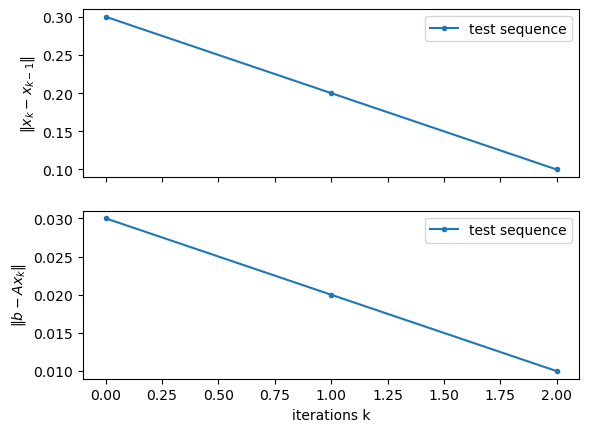

In [50]:
plot_cache = PlotCacheDiffRes([
    cache_callback
])

fig = plot_cache.plot()


それでは改めてJacobi法の実装に`callback`を引数に取るように変更する．


In [73]:
def jacobi_method(
    A: np.ndarray,
    b: np.ndarray,
    x0: np.ndarray | None = None,
    maxiter: int = 200,
    tol: float = 1e-8,
    callback: callable = None
) -> np.ndarray:
    """Jacobi method for solving Ax=b

    Args:
        A (np.ndarray): nxn matrix A
        b (np.ndarray): n-d vector b
        x0 (np.ndarray): n-d vector of initial value x0
        maxiter (int, optional): max iterations. Defaults to 200.
        tol (float, optional): tolerance. Defaults to 1e-8.
        callback (callable, ``callback(diff: float, res: float)``, optional): callback function. Defaults to None.

    Returns:
        (np.ndarray): n-d vector of the solution x
    """
    assert b.ndim == 1
    n = b.shape[0]
    assert A.shape == (n, n)

    if x0 is None:
        x0 = np.zeros(n)
    else:
        assert x0.shape == (n,)
    xk_1 = x0.copy()

    D = diag(A)
    LU = A.copy()
    np.fill_diagonal(LU, 0)

    for _ in range(maxiter):
        xk = (b - LU @ xk_1) / D

        diff_k = norm(xk - xk_1)
        residual_k = norm(b - A @ xk)

        if callback:
            callback(diff_k, residual_k)

        if diff_k < tol:
            break
        xk_1 = xk.copy()

    return xk


そしてインスタンス`cache_callback_jacobi`をコールバックとして設定し，実行する．

In [ ]:
cache_callback_jacobi = CacheDiffRes("Jacobi method")
x = jacobi_method(A, b, callback=cache_callback_jacobi)
print("x", x)


x [-3.57471261e+59 -2.57888048e+59  1.73607450e+59]


これは`np.linalg.solve()`の結果と一致する．

In [76]:
x_np = solve(A, b)
print("x", x)
print("x_np", x_np)
print("x == x_np", np.allclose(x, x_np))


x [-3.57471261e+59 -2.57888048e+59  1.73607450e+59]
x_np [2.56541452e+09 1.59036118e+08 1.35296190e+09]
x == x_np False


以下が解の収束の様子をプロットしたものである．

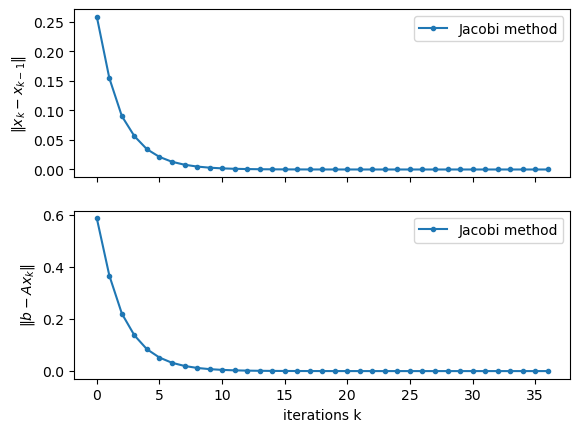

In [54]:
plot_cache = PlotCacheDiffRes([
    cache_callback_jacobi
])

fig = plot_cache.plot()

縦軸を対数でプロットするには以下のようにする．
対数で線形に誤差が減少していることが分かる．

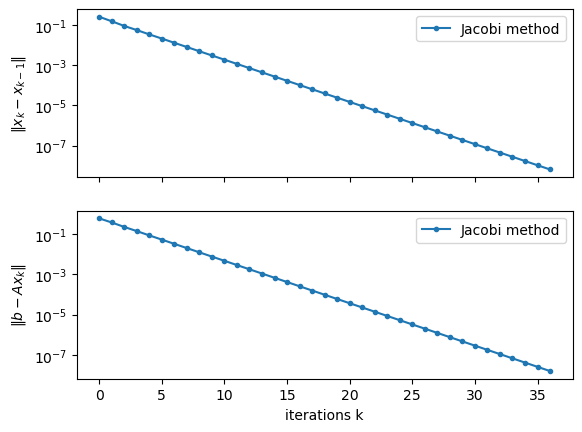

In [55]:
fig = plot_cache.plot(y_logscale=True)


なおコールバックインスタンス`cache_callback_jacobi`の`.get_diff()`と`.get_res()`でそれぞれ解の差分と残差のリストが得られる．
別個にプロットする場合にはこれらのメソッドが使える．

In [56]:
cache_callback_jacobi.get_diff()


array([2.58738888e-01, 1.54620231e-01, 9.03373782e-02, 5.64553061e-02,
       3.43534483e-02, 2.13039127e-02, 1.30778956e-02, 8.07964568e-03,
       4.97320284e-03, 3.06809006e-03, 1.89021314e-03, 1.16549980e-03,
       7.18286042e-04, 4.42806467e-04, 2.72929847e-04, 1.68242736e-04,
       1.03703257e-04, 6.39243313e-05, 3.94029959e-05, 2.42883948e-05,
       1.49714695e-05, 9.22852819e-06, 5.68851624e-06, 3.50644026e-06,
       2.16139106e-06, 1.33229556e-06, 8.21235313e-07, 5.06214720e-07,
       3.12033951e-07, 1.92339718e-07, 1.18559422e-07, 7.30807825e-08,
       4.50474585e-08, 2.77675399e-08, 1.71160880e-08, 1.05504655e-08,
       6.50337396e-09])

In [57]:
cache_callback_jacobi.get_res()


array([5.85746365e-01, 3.66192914e-01, 2.20256547e-01, 1.37083408e-01,
       8.38860310e-02, 5.19042293e-02, 3.19150613e-02, 1.97005173e-02,
       1.21328235e-02, 7.48266271e-03, 4.61088363e-03, 2.84272573e-03,
       1.75206869e-03, 1.08006288e-03, 6.65728947e-04, 4.10370266e-04,
       2.52950834e-04, 1.55921999e-04, 9.61107514e-05, 5.92434875e-05,
       3.65179840e-05, 2.25099467e-05, 1.38752633e-05, 8.55280459e-06,
       5.27200158e-06, 3.24969586e-06, 2.00313297e-06, 1.23474398e-06,
       7.61104005e-07, 4.69149358e-07, 2.89186642e-07, 1.78256486e-07,
       1.09878431e-07, 6.77297632e-08, 4.17490565e-08, 2.57343838e-08,
       1.58628377e-08])

### 1.5.3. <a id='toc1_5_3_'></a>[Gauss-Seidel法](#toc0_)

連立方程式は以下のように変形できた．
\begin{align*}
A \boldsymbol{x} &= \boldsymbol{b} \\
(U+D+L) \boldsymbol{x} &= \boldsymbol{b} \\
D \boldsymbol{x} &= \boldsymbol{b} - (L+U) \boldsymbol{x}\\
\boldsymbol{x} &= D^{-1} (\boldsymbol{b} - L \boldsymbol{x} - U \boldsymbol{x})\\
\end{align*}


Gauss-Seidel法は次式で解を更新する．
\begin{align*}
\boldsymbol{x}^{k}
&= D^{-1} (\boldsymbol{b} - L \boldsymbol{x}^{k} - U \boldsymbol{x}^{k-1})
\end{align*}
両辺に$\boldsymbol{x}^{k}$があるが，これは$L$が狭義下三角行列（対角成分が0）であるためである．
つまり$\boldsymbol{x}^{k} = (x_1^{(k)}, x_2^{(k)}, \ldots, x_n^{(k)})^T$について，
以下のように$i=1,2,\ldots,n$について逐次的に$x_i^{(k)}$を更新する際に，
すでに計算済みの$x_1^{(k)}, x_2^{(k)}, \ldots, x_{i-1}^{(k)}$を使う．


\begin{align*}
x_i^{(k)}
&=
\frac{1}{d_{ii}} \left(
b_i - \sum_{j=1}^{n} l_{ij} x_j^{(k)} -
\sum_{j=1}^n u_{ij} x_j^{(k-1)}
\right) \\
&=
\frac{1}{a_{ii}} \left(
b_i - \sum_{j = 1}^{i-1} a_{ij} x_j^{(k)} -
\sum_{j = i+1}^n a_{ij} x_j^{(k-1)}
\right)
\end{align*}

なお上式を変形すると次のようになる．
\begin{align*}
\boldsymbol{x}^{k}
&= \boldsymbol{x}^{k-1} + (L+D)^{-1} (\boldsymbol{b} - A \boldsymbol{x}^{k-1} )
\end{align*}
つまり$A$の下三角成分$L+D$の逆行列を$R$として，残差を用いて更新していることに相当する．
しかし$L+D$の逆行列を求めるのは，
解こうとしている連立方程式を解くと同じだけの計算量を必要とするため，
この形への変形は数値計算的に意味がない．

#### 1.5.3.1. <a id='toc1_5_3_1_'></a>[収束条件](#toc0_)

Gauss-Seidel法は，$A$が優対角行列または正定値対称行列ならば収束する．

行列$A$が正定値であるとは，任意のベクトル$\boldsymbol{x} \in R^n$に対して
\begin{align*}
\boldsymbol{x}^T A \boldsymbol{x} > 0
\end{align*}
が成り立つことである．また実対称行列の場合には$A$の固有値が全て正であることと同値である．

#### 1.5.3.2. <a id='toc1_5_3_2_'></a>[実装](#toc0_)

以下はGauss-Seidel法の実装である．
停止条件には$\| \boldsymbol{x}^k - \boldsymbol{x}^{k-1} \|$を用いている．


In [58]:
def gauss_seidel(
    A: np.ndarray,
    b: np.ndarray,
    x0: np.ndarray | None = None,
    maxiter: int = 50,
    tol: float = 1e-8,
    callback: callable = None
) -> np.ndarray:
    """Gauss-Seidel method for solving Ax=b

    Args:
        A (np.ndarray): nxn matrix A
        b (np.ndarray): n-d vector b
        x0 (np.ndarray): n-d vector of initial value x0
        maxiter (int, optional): max iterations. Defaults to 200.
        tol (float, optional): tolerance. Defaults to 1e-8.
        callback (callable, ``callback(diff: float, res: float)``, optional): callback function. Defaults to None.

    Returns:
        (np.ndarray): n-d vector of the solution x
    """
    assert b.ndim == 1
    n = b.shape[0]
    assert A.shape == (n, n)

    if x0 is None:
        x0 = np.zeros(n)
    else:
        assert x0.shape == (n,)
    xk_1 = x0.copy()
    xk = x0.copy()

    D = diag(A)
    LU = A.copy()
    np.fill_diagonal(LU, 0)

    for _ in range(maxiter):
        for i in range(n):
            xk[i] = (
                b[i] - (LU[i, :i] @ xk[:i] + LU[i, (i + 1):] @ xk_1[(i + 1):])
            ) / D[i]
            # xk[i] = (b[i] - LU[i] @ xk) / D[i]

        diff_k = norm(xk - xk_1)
        residual_k = norm(b - A @ xk)
        if callback:
            callback(diff_k, residual_k)

        if diff_k < tol:
            break
        xk_1 = xk.copy()

    return xk


In [59]:
cache_callback_gauss_seidel = CacheDiffRes("Gauss-Seidel")
x = gauss_seidel(A, b, callback=cache_callback_gauss_seidel)
print("x", x)
y = solve(A,b)
print(y)


x [ 0.13146102  0.16347531 -0.05716852]
[ 0.13146102  0.16347531 -0.05716851]


これは`np.linalg.solve()`の結果と一致する．

In [72]:
x_np = solve(A, b)
print("x", x)
print("x_np", x_np)
print("x == x_np", np.allclose(x, x_np))


x [2.56541452e+09 1.59036118e+08 1.35296190e+09]
x_np [2.56541452e+09 1.59036118e+08 1.35296190e+09]
x == x_np True


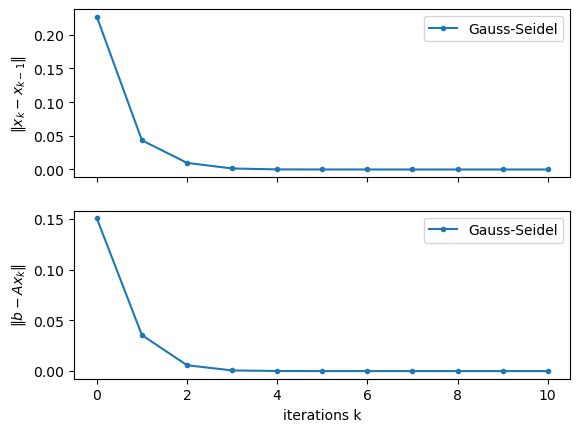

In [61]:
plot_cache = PlotCacheDiffRes(
    [cache_callback_gauss_seidel]
)

fig = plot_cache.plot()

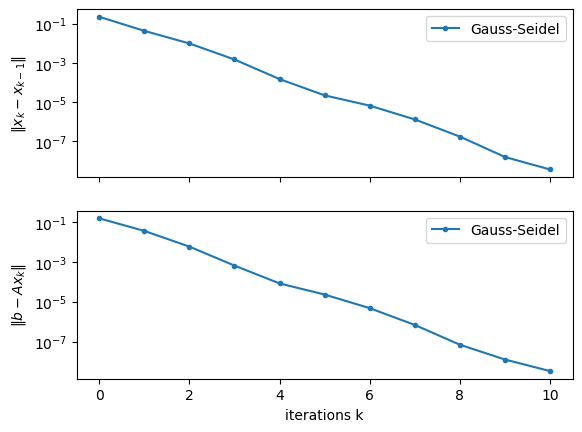

In [62]:
fig = plot_cache.plot(y_logscale=True)


Jacobi法とGauss-Seidel法を比較すると，
Gauss-Seidel法のほうが少ない反復で同じ残差を達成していることが分かる．

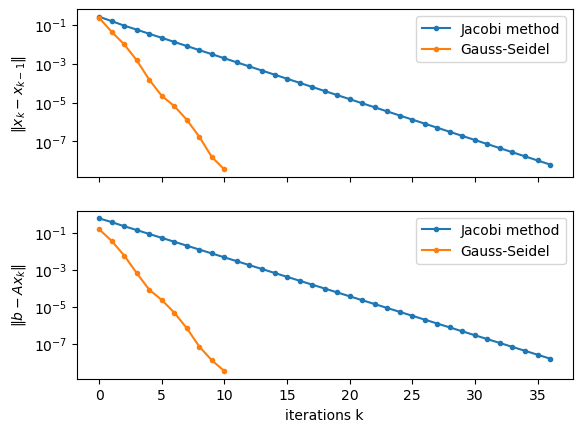

In [63]:
two_plots = PlotCacheDiffRes(
    [cache_callback_jacobi, cache_callback_gauss_seidel]
)
# fig = two_plots.plot()
fig = two_plots.plot(y_logscale=True)


### 1.5.4. <a id='toc1_5_4_'></a>[SOR法](#toc0_)


Gauss-Sidel法を以下のように改良した方法がSOR（successive over-relaxation）法である．

\begin{align*}
\tilde{\boldsymbol{x}}^{k} &= D^{-1} (\boldsymbol{b} - L \boldsymbol{x}^{k} - U \boldsymbol{x}^{k-1}) \\
\boldsymbol{x}^{k} &= \boldsymbol{x}^{k-1} + \omega (\tilde{\boldsymbol{x}}^{k} - \boldsymbol{x}^{k-1})
\end{align*}

ここで$1 < \omega < 2$は加速係数であり，問題に応じて適切な値を選択する必要がある．$\omega=1$がGauss-Seidel法に相当する．

SOR法は，$A$が正定値対称行列で$D + \omega L$が正則ならば$0<\omega<2$の範囲で収束する．

ただし$\omega$の決定は問題に依存する．

- [朝倉 数学ハンドブック 応用編, 朝倉書店, 2011.](https://www.asakura.co.jp/detail.php?book_code=11130) V 数値解析, 2.4 反復法, pp.292-293
  - > 最適な$\omega$の値$\omega_{\mathrm{opt}}$を決定することは一般に難しく（略）多くの場合$\omega_{\mathrm{opt}} > 1$であるが（略）各専門分野で経験的な値が用いられているようである．


<!-- 逆行列の計算に`inv()`を用いずに`solve()`を使うほうがよいのと同様に，
一般化逆行列の計算に`pinv()`を用いずに`lstsq()`を使うほうがよい．これは計算量の観点だけでなく，$m < n$という（式の数が変数の数よりも少ない）劣決定の場合や，$m=n$でも非正則な場合（$|A|=0$）でも，何らかの意味で解を計算できるからである（最小ノルム解など）． -->


## 1.6. <a id='toc1_6_'></a>[連立方程式の解の精度の評価](#toc0_)

上記の直接法や反復法によって得られた解$x$は，どの程度正確なのだろうか．また「正確」とは何を意味するのか．
それを議論するために，まず行列ノルムと条件数を説明する．


### 1.6.1. <a id='toc1_6_1_'></a>[行列ノルム](#toc0_)

ベクトルと同様に，行列にもノルムが定義できる．

- https://ja.wikipedia.org/wiki/%E8%A1%8C%E5%88%97%E3%83%8E%E3%83%AB%E3%83%A0
    > 線型代数学における行列ノルム（ぎょうれつノルム、英: matrix norm）は、ベクトルのノルムを行列に対し自然に一般化したものである。

$n$次正方行列$A$と逆行列$A^{-1}$に対して以下が成り立つ．

- $A A^{-1} = A^{-1} A = I$

ここで$\| A \|$を行列$A$のノルムとすると，以下が成り立つ．

- $\| A A^{-1} - I \| = 0$
- $\| A^{-1} A - I \| = 0$

ここで$I$は単位行列である．


In [64]:
n = 3
A = rng.random(size=(n, n))
I = np.eye(n)

print("A\n", A, sep="")
print("A^-1\n", inv(A), sep="")
print("A^-1 A == I", np.allclose(A @ inv(A), I))
print("||A^-1 A - I||", norm(A @ inv(A) - I))


A
[[0.14296349 0.62031954 0.79562723]
 [0.76386948 0.04040558 0.99823037]
 [0.5935531  0.03147124 0.55893944]]
A^-1
[[-8.70297065e-02 -3.17008216e+00  5.78544878e+00]
 [ 1.63140868e+00 -3.86639090e+00  4.58288587e+00]
 [ 5.62313445e-04  3.58409531e+00 -4.61266463e+00]]
A^-1 A == I True
||A^-1 A - I|| 8.59907668119085e-16


#### 1.6.1.1. <a id='toc1_6_1_1_'></a>[作用素ノルム](#toc0_)

ベクトル$\boldsymbol{x}$の$L_p$ノルムを$\| \boldsymbol{x} \|_p$とすると，
行列の作用素ノルム（operator norm）は次のように，ベクトルをどのくらい大きくするのかで定義される．
\begin{align*}
\| A \|_p = \sup_{\| \boldsymbol{x} \|_p \neq 0} \frac{\| A \boldsymbol{x} \|_p}{\| \boldsymbol{x} \|_p} \\
\end{align*}
また次のようにも定義される．
\begin{align*}
\| A \|_p = \sup_{\| \boldsymbol{x} \|_p = 1} \| A \boldsymbol{x} \|_p \\
\end{align*}

どちらもベクトルノルムを使って導かれた（誘導された）定義であり，
その意味で誘導ノルム（induced norm）とも呼ばれる．

- https://ja.wikipedia.org/wiki/%E4%BD%9C%E7%94%A8%E7%B4%A0%E3%83%8E%E3%83%AB%E3%83%A0
- https://ja.wikipedia.org/wiki/%E8%A1%8C%E5%88%97%E3%83%8E%E3%83%AB%E3%83%A0#%E8%AA%98%E5%B0%8E%E3%81%95%E3%82%8C%E3%81%9F%E3%83%8E%E3%83%AB%E3%83%A0
    > この行列ノルムは誘導ノルム (induced norm) あるいは作用素ノルム (operator norm) と呼ばれる。
- https://en.wikipedia.org/wiki/Matrix_norm#Matrix_norms_induced_by_vector_p-norms
    > These induced norms are different from the "entry-wise" p-norms and the Schatten p-norms for matrices treated below, which are also usually denoted by $\| A \|_p$


#### 1.6.1.2. <a id='toc1_6_1_2_'></a>[行列の$p$ノルム](#toc0_)

行列の$p$ノルム$\| A \|_p$の具体的な形は，
$p=1, 2, \infty$については以下のように与えられる．

- $p=1$：1ノルム（列の和の最大値）
    $$
    \| A \|_1 = \max_j \sum_{i} |a_{ij}|
    $$
    - [https://en.wikipedia.org/wiki/Matrix_norm#p_=_1,_%E2%88%9E](https://en.wikipedia.org/wiki/Matrix_norm#p_=_1,_%E2%88%9E)
- $p=2$：2ノルムまたはスペクトルノルム（最大特異値）
    $$
    \| A \|_2 = \sqrt{\lambda_\mathrm{max}} = \sigma_\mathrm{max}
    $$
    ここで$\lambda_\mathrm{max}$は$A^T A$の最大固有値，
    $\sigma_\mathrm{max}$は$A$の最大特異値．
    - https://en.wikipedia.org/wiki/Matrix_norm#Spectral_norm_(p_=_2)
    - もし$A$が実対称行列であれば，$A$自体の最大固有値を$\lambda_\mathrm{max}$とすれば
        $$
        \| A \|_2 = |\lambda_\mathrm{max}|
        $$
        最小固有値を$\lambda_\mathrm{min}$とすれば
        $$
        \| A^{-1} \|_2 = 1/|\lambda_\mathrm{min}|
        $$
- $p=\infty$：最大値ノルム（行の和の最大値）
    $$
    \| A \|_\infty = \max_i \sum_{j} |a_{ij}|
    $$
    つまり$\| A \|_1 = \| A^T \|_\infty$
    - [https://en.wikipedia.org/wiki/Matrix_norm#p_=_1,_%E2%88%9E](https://en.wikipedia.org/wiki/Matrix_norm#p_=_1,_%E2%88%9E)

#### 1.6.1.3. <a id='toc1_6_1_3_'></a>[誘導ノルム以外のノルム](#toc0_)

また誘導ノルムではないが，よく使われるノルムには以下のものがある．

- 核ノルム（$A$の固有値の和），またはトレースノルム（$A^T A$の行列平方根のトレース）．シャッテン$p$ノルムの$p=1$に相当．
    $$
    \| A \|_* = \mathrm{tr}(\sqrt{A^T A})
    = \sum_i \sqrt{\lambda_i}
    = \sum_i \sigma_i
    $$
    ここで$\lambda_i$は$A^T A$の固有値，
    $\sigma_i$は$A$の特異値．
    - https://en.wikipedia.org/wiki/Schatten_norm
    - https://en.wikipedia.org/wiki/Matrix_norm#Schatten_norms
    - https://ja.wikipedia.org/wiki/%E8%A1%8C%E5%88%97%E3%83%8E%E3%83%AB%E3%83%A0#%E3%82%B7%E3%83%A3%E3%83%83%E3%83%86%E3%83%B3%E3%83%8E%E3%83%AB%E3%83%A0
    - https://ja.wikipedia.org/wiki/%E8%A1%8C%E5%88%97%E3%83%8E%E3%83%AB%E3%83%A0#%E3%83%88%E3%83%AC%E3%83%BC%E3%82%B9%E3%83%8E%E3%83%AB%E3%83%A0
- フロベニウスノルム
    $$
    \| A \|_F = \sqrt{\sum_{i,j} a_{ij}^2}
    = \sqrt{\mathrm{tr}(A^T A)}
    = \sqrt{\sum_i \lambda_i }
    $$
    ここで$\lambda_i$は$A^T A$の固有値．
    - https://ja.wikipedia.org/wiki/%E8%A1%8C%E5%88%97%E3%83%8E%E3%83%AB%E3%83%A0#%E3%83%95%E3%83%AD%E3%83%99%E3%83%8B%E3%82%A6%E3%82%B9%E3%83%8E%E3%83%AB%E3%83%A0
    - https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm

有限次元の場合はどのノルムも同値（ノルムとして同じ位相的性質を持つ）であるため，
通常の計算や簡単な解析にはフロベニウスノルムが，
固有値や特異値を用いた解析には2ノルムや核ノルムなどが，よく用いられる．



#### 1.6.1.4. <a id='toc1_6_1_4_'></a>[numpyの行列ノルム](#toc0_)

numpyで行列ノルムを計算するには，ベクトルノルムと同じ`np.linalg.norm()`を用いる．

- [`numpy.linalg.norm()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)
    > Matrix or vector norm.


In [65]:
print("||A||_F  ", norm(A, ord="fro"))  # フロベニウスノルム（デフォルト）
print("||A||_1  ", norm(A, ord=1))  # 1ノルム
print("||A||_2  ", norm(A, ord=2))  # 2ノルム
print("||A||_*  ", norm(A, ord="nuc"))  # 核ノルム
print("||A||_inf", norm(A, ord=np.inf))  # 最大値ノルム


||A||_F   1.8126112829944057
||A||_1   2.352797037306077
||A||_2   1.6939956006108927
||A||_*   2.4259403918986213
||A||_inf 1.8025054341602131


#### 1.6.1.5. <a id='toc1_6_1_5_'></a>[ノルムの性質](#toc0_)

ノルムは以下の性質を満たす．

- $\| A \| \ge 0, \ \text{and} \ \| A \| = 0 \iff  A  = 0$
- $\alpha \in R, \| \alpha  A  \| = |\alpha| \ \| A \|$
- $\| A  + B \| \le \| A \| + \| B \|$：劣加法性

また誘導ノルムなら以下を満たす．

- $\| A B \| \le \| A \| \| B \|$：劣乗法性

特に

- $\| A \boldsymbol{x} \| \le \| A \| \| \boldsymbol{x} \|$

を満たす行列ノルムは，ベクトルノルムと整合している・両立するという．

また誘導ノルムなら
\begin{align*}
I &= A A^{-1} \\
\| I \| &\le \| A \| \| A^{-1}\| \\
\end{align*}
と$\| I \| = 1$より

- $\frac{1}{\| A \|} \le \| A^{-1}\|$
- $\| A \|^{-1} \le \| A^{-1} \|$

である．

なお$|A|$は$A$の行列式を表し，$\|A\|$はノルムを表す．
混乱を避けるため，$|A|$を$\mathrm{det}(A)$と書くことも多い．
もし行列式の絶対値を使うのであれば$| \mathrm{det}(A) |$と書き，$| |A| |$とは書かない．


In [66]:
n = 3
A = rng.random(size=(n, n))
B = rng.random(size=(n, n))
x = rng.random(n)
Ax = A @ x

print("A\n", A, sep="")
print("B\n", B, sep="")
print("||AB|| <= ||A|| ||B||", norm(A @ B) <= norm(A) * norm(B))

print("x", x)
print("Ax\n", Ax)
print("||Ax|| <= ||A|| ||x||", norm(Ax) <= norm(A) * norm(x))
print("1/||A|| <= ||A^-1||", 1 / norm(A) <= norm(inv(A)))


A
[[0.71228934 0.7748461  0.54628023]
 [0.02079855 0.75725346 0.35929217]
 [0.77630389 0.38372898 0.16607575]]
B
[[0.47576532 0.77833112 0.56446756]
 [0.8219156  0.95033552 0.01897113]
 [0.33318167 0.00810934 0.68079493]]
||AB|| <= ||A|| ||B|| True
x [0.50118303 0.03136124 0.86001161]
Ax
 [0.85109481 0.34316772 0.54393163]
||Ax|| <= ||A|| ||x|| True
1/||A|| <= ||A^-1|| True


### 1.6.2. <a id='toc1_6_2_'></a>[条件数](#toc0_)

連立方程式$A\boldsymbol{x} = \boldsymbol{b}$に誤差が混入した場合の誤差伝播を考える．


#### 1.6.2.1. <a id='toc1_6_2_1_'></a>[係数行列への誤差](#toc0_)

係数行列$A$に誤差$\Delta A$が混入した場合，
解が$\boldsymbol{x}$から$\boldsymbol{x} + \Delta \boldsymbol{x}$へ変化したとすると，次式が成り立つ．
\begin{align*}
(A + \Delta A)(\boldsymbol{x} + \Delta\boldsymbol{x}) &= \boldsymbol{b} \\
\Delta\boldsymbol{x} &= - A^{-1} \Delta A (\boldsymbol{x} - \Delta \boldsymbol{x})
\end{align*}

ここで行列ノルムの性質である劣乗法性
$
\| A \boldsymbol{x}\| \le \| A \| \| \boldsymbol{x} \|
$
を利用すると，
\begin{align*}
\| \Delta\boldsymbol{x} \| &\le \| A^{-1} \| \| \Delta A \| \| \boldsymbol{x} - \Delta \boldsymbol{x} \|
\\
\frac{\| \Delta\boldsymbol{x} \|}{\| \boldsymbol{x} - \Delta \boldsymbol{x} \|}
&\le
 \| A^{-1} \| \| A \| \frac{\| \Delta A \|}{\| A \|}
\end{align*}

#### 1.6.2.2. <a id='toc1_6_2_2_'></a>[条件数](#toc0_)

ここで$\| A^{-1} \| \| A \|$は$A$の条件数と呼ばれ，$\mathrm{cond}(A)$や$\kappa(A)$で表される．
2ノルムを用いる場合には
$$
\mathrm{cond}(A)_2 = \| A^{-1} \|_2 \| A \|_2
$$
である．

条件数は，$A$や$\boldsymbol{b}$の相対誤差の，$\boldsymbol{x}$の相対誤差への拡大率である．
つまり条件数が大きいと，解の相対誤差が大きくなる可能性がある．

- https://ja.wikipedia.org/wiki/%E6%9D%A1%E4%BB%B6%E6%95%B0#%E8%A1%8C%E5%88%97%E3%81%AE%E6%9D%A1%E4%BB%B6%E6%95%B0
    > - この場合（非常に大まかに言って）、bの変化によって解であるxが変化する率が条件数である。
    > - より正確に条件数を定義すると、xの相対誤差をbの相対誤差で割った最大比率である。

#### 1.6.2.3. <a id='toc1_6_2_3_'></a>[右辺ベクトルへの誤差](#toc0_)

同様にベクトル$\boldsymbol{b}$に誤差$\Delta\boldsymbol{b}$が混入した場合には
\begin{align*}
A (\boldsymbol{x} + \Delta\boldsymbol{x}) &= (\boldsymbol{b} + \Delta \boldsymbol{b}) \\
A \Delta\boldsymbol{x} &= \Delta \boldsymbol{b} \\
\Delta\boldsymbol{x} &= A^{-1} \Delta \boldsymbol{b} \\
\| \Delta\boldsymbol{x} \| &\le \| A^{-1} \| \| \Delta \boldsymbol{b} \|
\end{align*}
であり，また
\begin{align*}
A \boldsymbol{x} &= \boldsymbol{b} \\
\| A \| \| \boldsymbol{x} \| &\ge \| \boldsymbol{b} \| \\
\end{align*}
から次式が得られる．
\begin{align*}
\frac{\| \Delta\boldsymbol{x} \|}{\| A \| \| \boldsymbol{x} \|} &\le \frac{\| A^{-1} \| \| \Delta \boldsymbol{b} \|}{\| \boldsymbol{b} \|} \\
\frac{\| \Delta\boldsymbol{x} \|}{\| \boldsymbol{x} \|}
&\le
\mathrm{cond}(A) \frac{\| \Delta \boldsymbol{b} \|}{\| \boldsymbol{b} \|}
\end{align*}

#### 1.6.2.4. <a id='toc1_6_2_4_'></a>[係数行列と右辺への誤差](#toc0_)

$A$と$\boldsymbol{b}$の両方に誤差が混入した場合
\begin{align*}
(A + \Delta A)(\boldsymbol{x} + \Delta\boldsymbol{x}) &= (\boldsymbol{b} + \Delta \boldsymbol{b})
\end{align*}
には次式<sup>1</sup>が得られる．
\begin{align*}
\frac{\| \Delta\boldsymbol{x} \|}{\| \boldsymbol{x} \|}
&\le
\frac{\mathrm{cond}(A)}{1 - \| A^{-1} \| \| \Delta A \|}
\left(
\frac{\| \Delta A \|}{\| A \|} + \frac{\| \Delta \boldsymbol{b} \|}{\| \boldsymbol{b} \|}
\right)
\end{align*}


- <sup>1</sup>
  - [F・シャトラン, 行列の固有値, 丸善出版, 2012](https://www.maruzen-publishing.co.jp/item/b294297.html), p.119, 4.1 連立方程式の条件数の復習
  - [Gene H. Golub, Charles F. Van Loan, Matrix Computations, 4th edition, Johns Hopkins Univ Press, 2012](https://www.press.jhu.edu/books/title/10678/matrix-computations), p.89, 2.6.4 A Rigorous Norm Bound
  - [朝倉 数学ハンドブック 応用編, 朝倉書店, 2011](https://www.asakura.co.jp/detail.php?book_code=11130), pp.297, 2.6 解の評価と条件数


#### 1.6.2.5. <a id='toc1_6_2_5_'></a>[numpyの条件数](#toc0_)

条件数を計算するには`np.linalg.cond()`を用いる．なお条件数の定義でどのノルムを使うかは応用依存であり，引数`p`で指定できる．

- [`numpy.linalg.cond()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.cond.html)
    > Compute the condition number of a matrix.


In [67]:
n = 10
A = rng.random(size=(n, n))

print("cond(A)", cond(A))
print("cond(A)_1", cond(A, p=1))
print("cond(A)_2", cond(A, p=2))
print("cond(A)_inf", cond(A, p=np.inf))
print("cond(A)_F", cond(A, p='fro'))

invA = inv(A)
print("||A|| ||A^-1||", norm(A) * norm(invA))
print("||A|| ||A^-1||_1", norm(A, ord=1) * norm(invA, ord=1))
print("||A|| ||A^-1||_2", norm(A, ord=2) * norm(invA, ord=2))
print("||A|| ||A^-1||_F", norm(A, ord='fro') * norm(invA, ord='fro'))
print("||A|| ||A^-1||_*", norm(A, ord='nuc') * norm(invA, ord='nuc'))


cond(A) 50.398560748843394
cond(A)_1 120.15132465624265
cond(A)_2 50.398560748843394
cond(A)_inf 90.70068630198469
cond(A)_F 63.08425730422972
||A|| ||A^-1|| 63.08425730422972
||A|| ||A^-1||_1 120.15132465624265
||A|| ||A^-1||_2 50.398560748843366
||A|| ||A^-1||_F 63.08425730422972
||A|| ||A^-1||_* 265.15010617775164


### 1.6.3. <a id='toc1_6_3_'></a>[条件数による連立方程式の解の精度評価](#toc0_)

演習では，簡易な手法を自分で実装し，ライブラリ（`np.linalg.solve()`など）の解を真値として比較したり誤差を計算したりできるが，現実の問題では真値は与えられない．
それでも，解の精度を評価する必要がある．
一般的な方法は，これまで見てきたように残差のノルムを評価するものである．


In [68]:
n = 3
A = rng.random(size=(n, n))
print("A\n", A, sep="")
print("||A||", norm(A))
print("||A^-1||", norm(inv(A)))
print("det(A)", det(A))

b = rng.random(n)
print("b", b)

x = solve(A, b)
print("x", x)
r = b - A @ x
print("b - Ax", r)
print("||r||", norm(r))


A
[[0.29895675 0.23540131 0.15585568]
 [0.59483839 0.87790515 0.67327419]
 [0.25842111 0.33680549 0.35966536]]
||A|| 1.434052573509067
||A^-1|| 16.166681166453245
det(A) 0.01306473230330421
b [0.75059453 0.86854438 0.77968465]
x [ 4.26661326 -4.30417132  3.13282944]
b - Ax [0.00000000e+00 3.33066907e-16 0.00000000e+00]
||r|| 3.3306690738754696e-16


しかし条件数が大きい（不良設定の）場合には，残差ノルム$\|\boldsymbol{r}\|$が小さかったとしても誤差のノルム$\| \Delta \boldsymbol{x} \|$が小さいとは限らない．

$A$と$\boldsymbol{b}$は誤差がないとすると，残差は
\begin{align*}
A (\boldsymbol{x} + \Delta \boldsymbol{x}) &= \boldsymbol{b} \\
A \boldsymbol{x} + A \Delta \boldsymbol{x} &= \boldsymbol{b} \\
A \Delta \boldsymbol{x} &= \boldsymbol{b} - A \boldsymbol{x} = \boldsymbol{r} \\
\end{align*}


となり，この場合には次式が得られる．
\begin{align*}
\frac{\| \Delta \boldsymbol{x} \|}{\| \boldsymbol{x} \|}
&\le
\mathrm{cond}(A) \frac{\| \boldsymbol{r} \|}{\| \boldsymbol{b} \|}
\end{align*}
つまり条件数が大きい場合には，$A, \boldsymbol{b}$に誤差がなく，残差が小さかったとしても，解の相対誤差は大きくなる可能性がある．

- [William Layton and Myron Sussman, Numerical Linear Algebra, World Scientific Pub Co Inc., 2020](https://www.worldscientific.com/worldscibooks/10.1142/11926), 2.4 Error, Residual and Condition Number.
- [A. クアルテローニ, F. サレリ, P. ジェルヴァシオ, MATLABとOctaveによる科学技術計算 数値計算の理論と手法, 丸善出版, 2014](https://www.maruzen-publishing.co.jp/item/b294177.html), 第5章 線型方程式系, p.176, 例題5.10.


In [69]:
print("cond(A)", cond(A))
print("cond(A) * ||r||/||b||", cond(A) * norm(r) / norm(b))


cond(A) 20.26299831860995
cond(A) * ||r||/||b|| 4.8634482702329065e-15


上記の場合，残差ノルムは1e-14〜1e-16程度であり，条件数も大きくないため，それほど解に誤差はない（つまり解の相対誤差は高々1e-14程度である）．

しかし以下のように，Aの条件数が大きい場合には，解の相対誤差は大きくなる（以下の例では1e+2〜1e+3程度になる）可能性がある．

In [70]:
n = 3
A = rng.random(size=(n, n))
A = A.T @ A  # positive definite
w, U = np.linalg.eigh(A)
w[w.argmax()] = 1e+5  # largest (absolute) eigenvalue
w[w.argmin()] = 1e-5  # smallest (absolute) eigenvalue
A = U.T @ diag(w) @ U
A /= A.max()  # normalize
print("A\n", A, sep="")
print("||A||", norm(A))
print("||A^-1||", norm(inv(A)))
print("det(A)", det(A))

b = rng.random(n)
print("b", b)

x = solve(A, b)
print("x", x)
r = b - A @ x
print("b - Ax", r)
print("||r||", norm(r))

print("cond(A)", cond(A))
print("cond(A) * ||r||/||b||", cond(A) * norm(r) / norm(b))


A
[[ 0.23585959  0.32692794 -0.48565372]
 [ 0.32692794  0.45317754 -0.6731729 ]
 [-0.48565372 -0.6731729   1.        ]]
||A|| 1.6890251520564006
||A^-1|| 5920573747.42979
det(A) 3.4183177862698975e-15
b [0.28232267 0.56858132 0.45114856]
x [2.56541452e+09 1.59036118e+08 1.35296190e+09]
b - Ax [2.39325041e-08 9.96683558e-08 4.81342757e-08]
||r|| 1.1324069230152737e-07
cond(A) 10000000508.405334
cond(A) * ||r||/||b|| 1454.0451318600012


このように条件数が悪い場合，アルゴリズムの違いによって得られる解の一致する桁数は減少してしまう．
以下の例では，各種ソルバーで一致するのは6桁程度である．

In [71]:
with np.printoptions(precision=16, linewidth=100):

    print("np solve(A, b)   ", solve(A, b))
    print("inv(A) @ b       ", inv(A) @ b)
    print("pinv(A) @ b      ", np.linalg.pinv(A) @ b)
    print("np lstsq(A, b)   ", np.linalg.lstsq(A, b)[0])

    print("scipy solve(A, b)", scipy.linalg.solve(A, b, assume_a="gen"), "for general matrix")
    print("scipy solve(A, b)", scipy.linalg.solve(A, b, assume_a="sym"), "for symmetric matrix")
    print("scipy solve(A, b)", scipy.linalg.solve(A, b, assume_a="pos"), "for positive definite matrix")


np solve(A, b)    [2.5654145213516102e+09 1.5903611761090851e+08 1.3529619038363526e+09]
inv(A) @ b        [2.5654145213516102e+09 1.5903611761090854e+08 1.3529619038363528e+09]
pinv(A) @ b       [2.5654151718324623e+09 1.5903615792681172e+08 1.3529622468843699e+09]
np lstsq(A, b)    [2.5654151718324618e+09 1.5903615792681181e+08 1.3529622468843699e+09]
scipy solve(A, b) [2.5654145213516102e+09 1.5903611761090851e+08 1.3529619038363526e+09] for general matrix
scipy solve(A, b) [2.5654147661100001e+09 1.5903613278450096e+08 1.3529620329186256e+09] for symmetric matrix
scipy solve(A, b) [2.5654142755438828e+09 1.5903610237954563e+08 1.3529617742055755e+09] for positive definite matrix
